# Sample Integration Method Benchmarking

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 20.01.2023
- **Date of Last Modification:** 04.09.2023

## 1. Setup

### 1.1 Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../utils")

In [3]:
import argparse
import os
import gc
import pickle
import random
import shutil
import warnings
from copy import deepcopy
from datetime import datetime

import anndata as ad
import matplotlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import plottable
import scanpy as sc
import scipy.sparse as sp
import scvi
import seaborn as sns
import squidpy as sq
import torch
from GraphST import GraphST
from matplotlib import gridspec
from matplotlib.pyplot import rc_context
from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap
from plottable.formatters import tickcross
from plottable.plots import bar
from sklearn.decomposition import KernelPCA

from nichecompass.benchmarking import compute_clisis, compute_cas
from nichecompass.models import NicheCompass

from benchmarking_utils import *

from nichecompass.utils import (create_new_color_dict)

[rank: 0] Global seed set to 0
/home/aih/sebastian.birk/.local/lib/python3.9/site-packages/flax/struct.py:136: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/aih/sebastian.birk/.local/lib/python3.9/site-packages/flax/struct.py:136: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


### 1.2 Define Parameters

In [69]:
metric_cols_sample_integration = [
    "gcs", "mlami", "cas", "clisis", # spatial conservation
    "cari", "cnmi", "casw", "clisi", # biological conservation
    "nasw", # cluster separability
    "basw", "blisi" # batch correction "bgc"
]
metric_col_weights_sample_integration = [ # separate for each category (later multiplied with category_col_weights)
    (1/6), (1/6), (1/3), (1/3), # spatial conservation
    (1/4), (1/4), (1/4), (1/4), # biological conservation
    1.0, # cluster separability
    (1/3), (1/3), (1/3) # batch correction
]
metric_col_titles_sample_integration = [
    "Graph Connectivity Similarity",
    "Maximum Leiden Adjusted Mutual Info",
    "Cell Type Affinity Similarity",
    "Cell Type Local Inverse Simpson's Index Similarity",
    "Cell Type Adjusted Rand Index",
    "Cell Type Normalized Mutual Info",
    "Cell Type Average Silhouette Width",
    "Cell Type Local Inverse Simpson's Index",
    "Cluster Average Silhouette Width",
    "Batch Average Silhouette Width",
    "Batch Graph Connectivity",
    "Batch Local Inverse Simpson's Index"
]
metric_cols_single_sample = metric_cols_sample_integration[:-3]
metric_col_weights_single_sample = metric_col_weights_sample_integration[:-3]
metric_col_titles_single_sample = metric_col_titles_sample_integration[:-3]

category_cols_sample_integration = [
    "Spatial Conservation Score",
    "Biological Conservation Score",
    "Cluster Separability Score",
    "Batch Correction Score"]
category_col_weights_sample_integration = [
    1,
    1,
    1,
    1]
category_col_titles_sample_integration = [
    "Spatial Conservation Score",
    "Biological Conservation Score",
    "Cluster Separability Score",
    "Batch Correction Score"]
category_col_weights_single_sample = category_col_weights_sample_integration[:-1]
category_cols_single_sample = category_cols_sample_integration[:-1]
category_col_titles_single_sample = [
    "Spatial Conservation Score (33%)",
    "Biological Conservation Score (33%)",
    "Cluster Separability Score (33%)"]

### 1.3 Run Notebook Setup

In [5]:
sc.set_figure_params(figsize=(6, 6))
sns.set_style("whitegrid", {'axes.grid' : False})

In [6]:
# Ignore future warnings and user warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [7]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

In [8]:
# Set mlflow tracking server (run it on the defined port)
mlflow.set_tracking_uri("http://localhost:8889")

### 1.4 Configure Paths and Create Directories

In [9]:
data_folder_path = "../../datasets/srt_data/gold"
artifact_folder_path = f"../../artifacts"
benchmarking_folder_path = f"{artifact_folder_path}/sample_integration_method_benchmarking"

## 2. Method Benchmarking

- Run all model notebooks in the ```notebooks/sample_integration_method_benchmarking``` directory before continuing.

### 2.1 Retrieve NicheCompass Runs

#### 2.1.1 seqFISH Mouse Organogenesis

#### 2.1.2 seqFISH Mouse Organogenesis Imputed

#### 2.1.3 nanoString CosMx SMI Human Non-Small-Cell Lung Cancer (NSCLC)

In [ ]:
# Store NicheCompass GCN encoder W/O FoV embedding results in benchmarking folder
task = "sample_integration_method_benchmarking"
conv_layer_encoder = "gcnconv"
datasets = [
    #"nanostring_cosmx_human_nsclc",
    #"nanostring_cosmx_human_nsclc_subsample_50pct",
    #"nanostring_cosmx_human_nsclc_subsample_25pct",
    #"nanostring_cosmx_human_nsclc_subsample_10pct",
    #"nanostring_cosmx_human_nsclc_subsample_5pct",
    #"nanostring_cosmx_human_nsclc_subsample_1pct",
]
timestamps = [
    #"21082023_162330_1",
    #"21082023_205148_1",
    #"22082023_084950_1",
    #"22082023_093531_1",
    #"22082023_093728_1",
    #"22082023_093729_1",
]

for dataset, timestamp in zip(datasets, timestamps):
    source_path = f"{artifact_folder_path}/{dataset}/results/{conv_layer_encoder}_{task}/{timestamp}/{dataset}_{conv_layer_encoder}_{task}.h5ad"
    destination_path = f"{artifact_folder_path}/{task}/{dataset}_nichecompass_{conv_layer_encoder}.h5ad"
    shutil.copy(source_path, destination_path)

In [ ]:
# Store NicheCompass GCN encoder with contrastive loss results in benchmarking folder
task = "sample_integration_method_benchmarking"
conv_layer_encoder = "gcnconv"
datasets = [
    #"nanostring_cosmx_human_nsclc",
    #"nanostring_cosmx_human_nsclc_subsample_50pct",
    #"nanostring_cosmx_human_nsclc_subsample_25pct",
    #"nanostring_cosmx_human_nsclc_subsample_10pct",
    #"nanostring_cosmx_human_nsclc_subsample_5pct",
    #"nanostring_cosmx_human_nsclc_subsample_1pct",
]
timestamps = [
    #"02092023_195625_6",
    #"02092023_215804_5",
    #"02092023_215804_1",
    #"02092023_221650_1",
    #"02092023_222739_1",
    #"02092023_232258_1",
]

for dataset, timestamp in zip(datasets, timestamps):
    source_path = f"{artifact_folder_path}/{dataset}/results/{conv_layer_encoder}_{task}/{timestamp}/{dataset}_{conv_layer_encoder}_{task}.h5ad"
    destination_path = f"{artifact_folder_path}/{task}/{dataset}_nichecompass_{conv_layer_encoder}_cont.h5ad"
    shutil.copy(source_path, destination_path)

In [ ]:
# Store NicheCompass GATv2 encoder with contrastive loss results in benchmarking folder
task = "sample_integration_method_benchmarking"
conv_layer_encoder = "gatv2conv"
datasets = [
    #"nanostring_cosmx_human_nsclc",
    #"nanostring_cosmx_human_nsclc_subsample_50pct",
    "nanostring_cosmx_human_nsclc_subsample_25pct",
    #"nanostring_cosmx_human_nsclc_subsample_10pct",
    #"nanostring_cosmx_human_nsclc_subsample_5pct",
    #"nanostring_cosmx_human_nsclc_subsample_1pct",
]
timestamps = [
    #"30082023_174502_6",
    #"30082023_183405_5",
    "04092023_094021_2",
    #"02092023_171351_1",
    #"03092023_120506_1",
    #"30082023_192351_1",
]

for dataset, timestamp in zip(datasets, timestamps):
    source_path = f"{artifact_folder_path}/{dataset}/results/{conv_layer_encoder}_{task}/{timestamp}/{dataset}_{conv_layer_encoder}_{task}.h5ad"
    destination_path = f"{artifact_folder_path}/{task}/{dataset}_nichecompass_{conv_layer_encoder}_cont.h5ad"
    shutil.copy(source_path, destination_path)

In [ ]:
# Add missing runs for 'nanostring_cosmx_human_nsclc_subsample_25pct'
dataset = "nanostring_cosmx_human_nsclc_subsample_25pct"
conv_layer_encoder = "gatv2conv"
timestamp = "04092023_094005_1"

adata1 = sc.read_h5ad(f"{benchmarking_folder_path}/{dataset}_nichecompass_{conv_layer_encoder}_cont.h5ad")
adata2 = sc.read_h5ad(f"{artifact_folder_path}/{dataset}/results/{conv_layer_encoder}_sample_integration_method_benchmarking/{timestamp}/{dataset}_{conv_layer_encoder}_sample_integration_method_benchmarking.h5ad")

for run_number in [4]:
    adata1.uns[f"nichecompass_latent_run{run_number}_umap"] = adata2.uns[f"nichecompass_latent_run{run_number}_umap"]
    adata1.uns[f"nichecompass_model_training_duration_run{run_number}"] = adata2.uns[f"nichecompass_model_training_duration_run{run_number}"]
    adata1.obsm[f"nichecompass_latent_run{run_number}"] = adata2.obsm[f"nichecompass_latent_run{run_number}"]
    adata1.obsp[f"nichecompass_latent_run{run_number}_connectivities"] = adata2.obsp[f"nichecompass_latent_run{run_number}_connectivities"]
    adata1.obsp[f"nichecompass_latent_run{run_number}_distances"] = adata2.obsp[f"nichecompass_latent_run{run_number}_distances"]
    
del(adata2)
gc.collect()

timestamp = "04092023_094213_3"
adata2 = sc.read_h5ad(f"{artifact_folder_path}/{dataset}/results/{conv_layer_encoder}_sample_integration_method_benchmarking/{timestamp}/{dataset}_{conv_layer_encoder}_sample_integration_method_benchmarking.h5ad")

for run_number in [6]:
    adata1.uns[f"nichecompass_latent_run{run_number}_umap"] = adata2.uns[f"nichecompass_latent_run{run_number}_umap"]
    adata1.uns[f"nichecompass_model_training_duration_run{run_number}"] = adata2.uns[f"nichecompass_model_training_duration_run{run_number}"]
    adata1.obsm[f"nichecompass_latent_run{run_number}"] = adata2.obsm[f"nichecompass_latent_run{run_number}"]
    adata1.obsp[f"nichecompass_latent_run{run_number}_connectivities"] = adata2.obsp[f"nichecompass_latent_run{run_number}_connectivities"]
    adata1.obsp[f"nichecompass_latent_run{run_number}_distances"] = adata2.obsp[f"nichecompass_latent_run{run_number}_distances"]
    
del(adata2)
gc.collect()

timestamp = ""
adata2 = sc.read_h5ad(f"{artifact_folder_path}/{dataset}/results/{conv_layer_encoder}_sample_integration_method_benchmarking/{timestamp}/{dataset}_{conv_layer_encoder}_sample_integration_method_benchmarking.h5ad")

for run_number in [7]:
    adata1.uns[f"nichecompass_latent_run{run_number}_umap"] = adata2.uns[f"nichecompass_latent_run{run_number}_umap"]
    adata1.uns[f"nichecompass_model_training_duration_run{run_number}"] = adata2.uns[f"nichecompass_model_training_duration_run{run_number}"]
    adata1.obsm[f"nichecompass_latent_run{run_number}"] = adata2.obsm[f"nichecompass_latent_run{run_number}"]
    adata1.obsp[f"nichecompass_latent_run{run_number}_connectivities"] = adata2.obsp[f"nichecompass_latent_run{run_number}_connectivities"]
    adata1.obsp[f"nichecompass_latent_run{run_number}_distances"] = adata2.obsp[f"nichecompass_latent_run{run_number}_distances"]
    
del(adata2)
gc.collect()

timestamp = "03092023_115037_1"
adata2 = sc.read_h5ad(f"{artifact_folder_path}/{dataset}/results/{conv_layer_encoder}_sample_integration_method_benchmarking/{timestamp}/{dataset}_{conv_layer_encoder}_sample_integration_method_benchmarking.h5ad")

for run_number in [8]:
    adata1.uns[f"nichecompass_latent_run{run_number}_umap"] = adata2.uns[f"nichecompass_latent_run{run_number}_umap"]
    adata1.uns[f"nichecompass_model_training_duration_run{run_number}"] = adata2.uns[f"nichecompass_model_training_duration_run{run_number}"]
    adata1.obsm[f"nichecompass_latent_run{run_number}"] = adata2.obsm[f"nichecompass_latent_run{run_number}"]
    adata1.obsp[f"nichecompass_latent_run{run_number}_connectivities"] = adata2.obsp[f"nichecompass_latent_run{run_number}_connectivities"]
    adata1.obsp[f"nichecompass_latent_run{run_number}_distances"] = adata2.obsp[f"nichecompass_latent_run{run_number}_distances"]
    
adata1.write(f"{benchmarking_folder_path}/{dataset}_nichecompass_{conv_layer_encoder}_cont.h5ad")

##### 2.1.3.2 Fix Observation Uniqueness

In [ ]:
conv_layer_encoder = "gatv2conv_cont"
dataset = "nanostring_cosmx_human_nsclc_subsample_1pct"

adata = sc.read_h5ad(f"{artifact_folder_path}/sample_integration_method_benchmarking/{dataset}_nichecompass_{conv_layer_encoder}.h5ad")
adata.obs_names_make_unique()
adata.write(f"{artifact_folder_path}/sample_integration_method_benchmarking/{dataset}_nichecompass_{conv_layer_encoder}.h5ad")

##### 2.1.3.3 Metrics Computation Split Due to Memory Constraints

In [ ]:
# Only keep 1 run for metrics computation due to memory constraints
conv_layer_encoder = "gatv2conv_fov" # "gcnconv", "gcnconv", "gcnconv_cont"
dataset = "nanostring_cosmx_human_nsclc_subsample_25pct" # "nanostring_cosmx_human_nsclc_subsample_50pct", # nanostring_cosmx_human_nsclc

for part in [1, 2, 3, 4, 5, 6, 7, 8]:
    adata = sc.read_h5ad(f"{artifact_folder_path}/sample_integration_method_benchmarking/{dataset}_nichecompass_{conv_layer_encoder}.h5ad")
    for run_number in [1, 2, 3, 4, 5, 6, 7, 8]:
        if run_number != part:
            del(adata.uns[f"nichecompass_latent_run{run_number}_umap"])
            del(adata.uns[f"nichecompass_model_training_duration_run{run_number}"])
            del(adata.obsp[f"nichecompass_latent_run{run_number}_connectivities"])
            del(adata.obsp[f"nichecompass_latent_run{run_number}_distances"])
            del(adata.obsm[f"nichecompass_latent_run{run_number}"])
    adata.write(f"{artifact_folder_path}/sample_integration_method_benchmarking/{dataset}_nichecompass_{conv_layer_encoder}_part{part}.h5ad")

In [ ]:
model = "gatv2conv_cont" # "gcnconv", "gcnconv_cont"

df = pd.read_csv(f"{artifact_folder_path}/sample_integration_method_benchmarking/nanostring_cosmx_human_nsclc_nichecompass_{model}_part1_metrics.csv")
for run_number in [2, 3, 4, 5, 6, 7, 8]:
    df2 = pd.read_csv(f"{artifact_folder_path}/sample_integration_method_benchmarking/nanostring_cosmx_human_nsclc_nichecompass_{model}_part{run_number}_metrics.csv")
    df = pd.concat([df, df2], ignore_index=True)
df.to_csv(f"{artifact_folder_path}/sample_integration_method_benchmarking/nanostring_cosmx_human_nsclc_nichecompass_{model}_metrics.csv", index=False)

In [ ]:
pct = 50
model = "gcnconv_fov"

df = pd.read_csv(f"{artifact_folder_path}/sample_integration_method_benchmarking/nanostring_cosmx_human_nsclc_subsample_{pct}pct_nichecompass_{model}_metrics1.csv")
for run_number in [2, 3, 4, 5, 6, 7, 8]:
    df2 = pd.read_csv(f"../artifacts/sample_integration_method_benchmarking/nanostring_cosmx_human_nsclc_subsample_{pct}pct_nichecompass_{model}_metrics{run_number}.csv")
    df = pd.concat([df, df2], ignore_index=True)
df.to_csv(f"{artifact_folder_path}/sample_integration_method_benchmarking/nanostring_cosmx_human_nsclc_subsample_{pct}pct_nichecompass_{model}_metrics.csv", index=False)

In [ ]:
model = "gatv2conv_fov" # "gatv2conv"

df = pd.read_csv(f"{artifact_folder_path}/sample_integration_method_benchmarking/nanostring_cosmx_human_nsclc_nichecompass_{model}_part1_metrics1.csv")
for part, run_number in zip([1, 1, 1, 2, 2, 2, 2], [2, 3, 4, 5, 6, 7, 8]):
    df2 = pd.read_csv(f"{artifact_folder_path}/sample_integration_method_benchmarking/nanostring_cosmx_human_nsclc_nichecompass_{model}_part{part}_metrics{run_number}.csv")
    df = pd.concat([df, df2], ignore_index=True)
df.to_csv(f"{artifact_folder_path}/sample_integration_method_benchmarking/nanostring_cosmx_human_nsclc_nichecompass_{model}_metrics.csv", index=False)

## 2. Sample Integration Evaluation

### 2.1 Create Benchmarking Metrics Plots & Run Time Plots

#### 2.1.1 nanoString CosMx SMI Human Non-Small-Cell Lung Cancer (NSCLC)

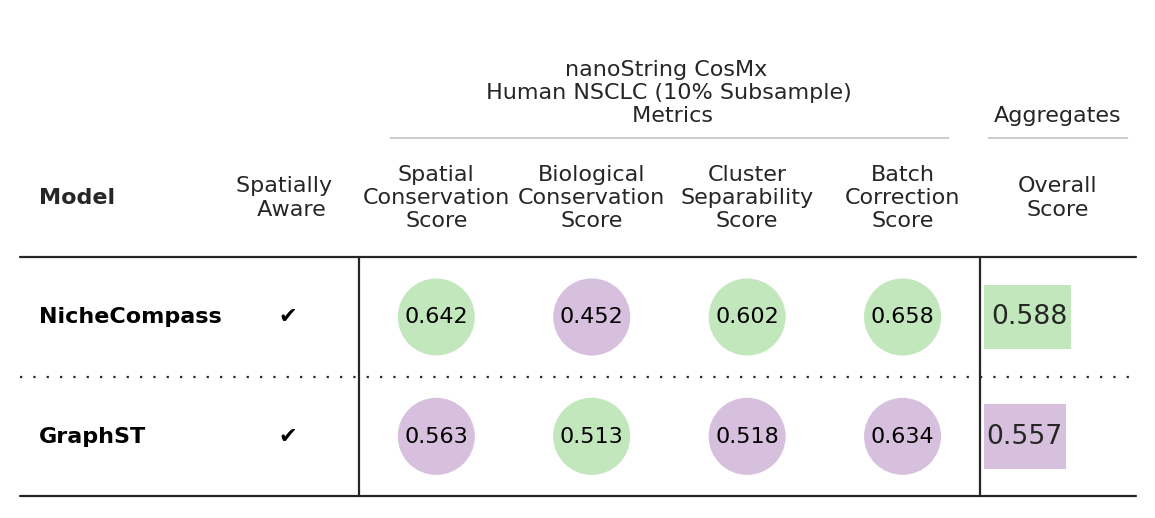

In [165]:
### Main figure: 10 pct subsample comparison NC vs GraphST ###
datasets = ["nanostring_cosmx_human_nsclc_subsample_10pct"]
models = ["nichecompass_gatv2conv_fov",
          "graphst_paste"]

summary_df = pd.DataFrame()
for dataset in datasets:
    for model in models:
        try:
            benchmark_df = pd.read_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv")
            #adata = sc.read_h5ad(f"../../artifacts/single_sample_method_benchmarking/{dataset}_{model}.h5ad")
            #training_durations = []
            #for run_number in [1, 2, 3, 4, 5, 6, 7, 8]:
            #    training_durations.append(adata.uns[f"{model.split('_')[0]}_model_training_duration_run{run_number}"])
            #benchmark_df["run_time"] = training_durations
            #benchmark_df = benchmark_df[["dataset", "run_number", "run_time", "gcs", "mlami", "cas", "clisis", "nasw", "cnmi", "cari", "casw", "clisi"]]
            #benchmark_df.to_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv", index=False)
            benchmark_df["model"] = model
            benchmark_df[category_cols_sample_integration[0]] = np.average(benchmark_df[metric_cols_sample_integration[:4]], weights=metric_col_weights_sample_integration[:4], axis=1)
            benchmark_df[category_cols_sample_integration[1]] = np.average(benchmark_df[metric_cols_sample_integration[4:8]], weights=metric_col_weights_sample_integration[4:8], axis=1)
            benchmark_df[category_cols_sample_integration[2]] = np.average(benchmark_df[metric_cols_sample_integration[8:9]], weights=metric_col_weights_sample_integration[8:9], axis=1)
            benchmark_df[category_cols_sample_integration[3]] = np.average(benchmark_df[metric_cols_sample_integration[9:11]], weights=metric_col_weights_sample_integration[9:11], axis=1)
            benchmark_df["Overall Score"] = np.average(benchmark_df[category_cols_sample_integration[:4]], weights=category_col_weights_sample_integration[:4] ,axis=1)
            summary_df = pd.concat([summary_df, benchmark_df], ignore_index=True)
        except FileNotFoundError:
            print(f"Did not find file {benchmarking_folder_path}/{dataset}_{model}_metrics.csv. Continuing...")
            missing_run_data = {
                "dataset": [dataset] * 8,
                "model": [model] * 8,
                "run_number": [1, 2, 3, 4, 5, 6, 7, 8],
                "run_time": [np.nan] * 8
            }
            missing_run_df = pd.DataFrame(missing_run_data)
            summary_df = summary_df.append(missing_run_df, ignore_index=True)
            continue
 
# Reformat for plot
summary_df.replace({"nichecompass_gatv2conv_fov": "NicheCompass",
                    "graphst_paste": "GraphST"}, inplace=True)

# Plot over all loss weights combinations
# Prepare metrics table plot
group_cols = ["dataset", "model"]
aggregate_df = summary_df.groupby(group_cols).mean("Overall Score").sort_values("Overall Score", ascending=False)[
    category_cols_sample_integration].reset_index()

unrolled_df = pd.melt(aggregate_df, 
   id_vars=group_cols,
   value_vars=category_cols_sample_integration, # metric_cols_single_sample,
   var_name="score_type", 
   value_name="score")

# Create spatial indicator column
def is_spatially_aware_model(row):
    if row["model"] in ["NicheCompass GCN", "NicheCompass", "DeepLinc", "GraphST", "SageNet"]:
        return True
    return False
unrolled_df["spatially_aware"] = unrolled_df.apply(lambda row: is_spatially_aware_model(row), axis=1)
unrolled_df = unrolled_df[["dataset", "spatially_aware", "model", "score_type", "score"]]

# Order datasets
unrolled_df["dataset"] = pd.Categorical(unrolled_df["dataset"], categories=datasets, ordered=True)
unrolled_df = unrolled_df.sort_values(by="dataset")

#print(summary_df["model"].value_counts())
#print(summary_df[summary_df.isna().any(axis=1)])

summary_df["model"] = summary_df["model"].replace("NicheCompass GCN", "NicheCompass Light")
summary_df["model"] = summary_df["model"].replace("NicheCompass GATv2", "NicheCompass")

summary_df["dataset"] = summary_df["dataset"].replace(
    {"nanostring_cosmx_human_nsclc_subsample_10pct": "nanoString CosMx Human NSCLC"})

summary_df = summary_df[summary_df["run_number"] == 2]

# Plot table
plot_simple_metrics_table(
    df=unrolled_df,
    model_col="model",
    model_col_width=1.4,
    group_col="dataset",
    metric_cols=category_cols_sample_integration, # metric_cols_single_sample,
    metric_col_weights=category_col_weights_sample_integration, # metric_col_weights_single_sample,
    metric_col_titles=[col.replace(" ", "\n") for col in category_col_titles_sample_integration],
    metric_col_width=1.1, # 0.8,
    plot_width=9, # 32,
    plot_height=4,
    show=True,
    save_dir=benchmarking_folder_path,
    save_name=f"benchmarking_metrics_nanostring_cosmx_human_nsclc_subsample_10pct_run2.svg")

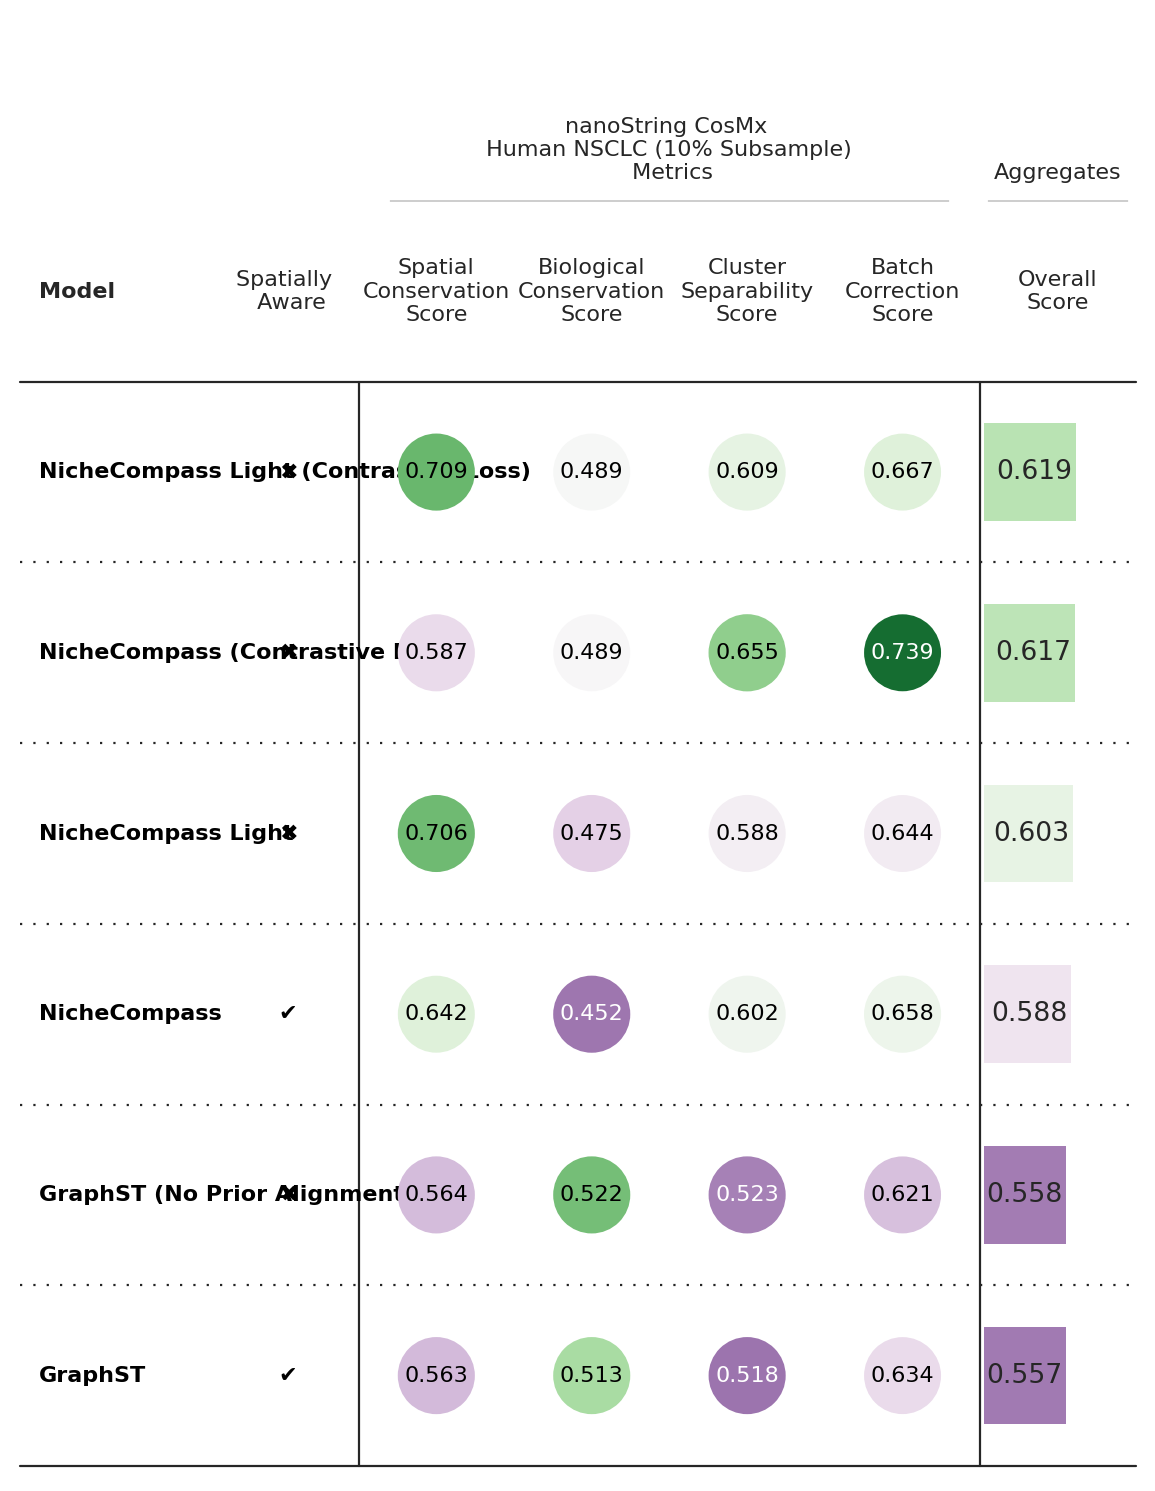

In [79]:
### Supplementary figure: 10 pct subsample comparison NC vs GraphST variations ###
datasets = ["nanostring_cosmx_human_nsclc_subsample_10pct"]
models = ["nichecompass_gatv2conv_fov",
          "nichecompass_gatv2conv_cont",
          #"nichecompass_gatv2conv",
          "nichecompass_gcnconv_fov",
          "nichecompass_gcnconv_cont",
          #"nichecompass_gcnconv",
          "graphst_paste",
          "graphst"]

summary_df = pd.DataFrame()
for dataset in datasets:
    for model in models:
        try:
            benchmark_df = pd.read_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv")
            #adata = sc.read_h5ad(f"../../artifacts/single_sample_method_benchmarking/{dataset}_{model}.h5ad")
            #training_durations = []
            #for run_number in [1, 2, 3, 4, 5, 6, 7, 8]:
            #    training_durations.append(adata.uns[f"{model.split('_')[0]}_model_training_duration_run{run_number}"])
            #benchmark_df["run_time"] = training_durations
            #benchmark_df = benchmark_df[["dataset", "run_number", "run_time", "gcs", "mlami", "cas", "clisis", "nasw", "cnmi", "cari", "casw", "clisi"]]
            #benchmark_df.to_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv", index=False)
            benchmark_df["model"] = model
            benchmark_df[category_cols_sample_integration[0]] = np.average(benchmark_df[metric_cols_sample_integration[:4]], weights=metric_col_weights_sample_integration[:4], axis=1)
            benchmark_df[category_cols_sample_integration[1]] = np.average(benchmark_df[metric_cols_sample_integration[4:8]], weights=metric_col_weights_sample_integration[4:8], axis=1)
            benchmark_df[category_cols_sample_integration[2]] = np.average(benchmark_df[metric_cols_sample_integration[8:9]], weights=metric_col_weights_sample_integration[8:9], axis=1)
            benchmark_df[category_cols_sample_integration[3]] = np.average(benchmark_df[metric_cols_sample_integration[9:11]], weights=metric_col_weights_sample_integration[9:11], axis=1)
            benchmark_df["Overall Score"] = np.average(benchmark_df[category_cols_sample_integration[:4]], weights=category_col_weights_sample_integration[:4] ,axis=1)
            summary_df = pd.concat([summary_df, benchmark_df], ignore_index=True)
        except FileNotFoundError:
            print(f"Did not find file {benchmarking_folder_path}/{dataset}_{model}_metrics.csv. Continuing...")
            missing_run_data = {
                "dataset": [dataset] * 8,
                "model": [model] * 8,
                "run_number": [1, 2, 3, 4, 5, 6, 7, 8],
                "run_time": [np.nan] * 8
            }
            missing_run_df = pd.DataFrame(missing_run_data)
            summary_df = summary_df.append(missing_run_df, ignore_index=True)
            continue
 
# Reformat for plot
summary_df.replace({"nichecompass_gatv2conv_fov": "NicheCompass",
                    "nichecompass_gatv2conv_cont": "NicheCompass (Contrastive Loss)",
                    "nichecompass_gatv2conv": "NicheCompass (No FoV Embedding)",
                    "nichecompass_gcnconv_fov": "NicheCompass Light",
                    "nichecompass_gcnconv_cont": "NicheCompass Light (Contrastive Loss)",
                    "nichecompass_gcnconv": "NicheCompass Light (No FoV Embedding)",
                    "graphst_paste": "GraphST",
                    "graphst": "GraphST (No Prior Alignment)"}, inplace=True)

# Plot over all loss weights combinations
# Prepare metrics table plot
group_cols = ["dataset", "model"]
aggregate_df = summary_df.groupby(group_cols).mean("Overall Score").sort_values("Overall Score", ascending=False)[
    category_cols_sample_integration].reset_index()

unrolled_df = pd.melt(aggregate_df, 
   id_vars=group_cols,
   value_vars=category_cols_sample_integration, # metric_cols_single_sample,
   var_name="score_type", 
   value_name="score")

# Create spatial indicator column
def is_spatially_aware_model(row):
    if row["model"] in ["NicheCompass GCN", "NicheCompass", "DeepLinc", "GraphST", "SageNet"]:
        return True
    return False
unrolled_df["spatially_aware"] = unrolled_df.apply(lambda row: is_spatially_aware_model(row), axis=1)
unrolled_df = unrolled_df[["dataset", "spatially_aware", "model", "score_type", "score"]]

# Order datasets
unrolled_df["dataset"] = pd.Categorical(unrolled_df["dataset"], categories=datasets, ordered=True)
unrolled_df = unrolled_df.sort_values(by="dataset")

#print(summary_df["model"].value_counts())
#print(summary_df[summary_df.isna().any(axis=1)])

summary_df["model"] = summary_df["model"].replace("NicheCompass GCN", "NicheCompass Light")
summary_df["model"] = summary_df["model"].replace("NicheCompass GATv2", "NicheCompass")

summary_df["dataset"] = summary_df["dataset"].replace(
    {"nanostring_cosmx_human_nsclc_subsample_10pct": "nanoString CosMx Human NSCLC"})

summary_df = summary_df[summary_df["run_number"] == 2]

# Plot table
plot_simple_metrics_table(
    df=unrolled_df,
    model_col="model",
    model_col_width=1.4,
    group_col="dataset",
    metric_cols=category_cols_sample_integration, # metric_cols_single_sample,
    metric_col_weights=category_col_weights_sample_integration, # metric_col_weights_single_sample,
    metric_col_titles=[col.replace(" ", "\n") for col in category_col_titles_sample_integration],
    metric_col_width=1.1, # 0.8,
    plot_width=9, # 32,
    plot_height=12,
    show=True,
    save_dir=benchmarking_folder_path,
    save_name=f"benchmarking_metrics_nanostring_cosmx_human_nsclc_subsample_10pct_run2.svg")

In [ ]:
datasets = ["nanostring_cosmx_human_nsclc",
            "nanostring_cosmx_human_nsclc_subsample_50pct",
            "nanostring_cosmx_human_nsclc_subsample_25pct",
            "nanostring_cosmx_human_nsclc_subsample_10pct",
            "nanostring_cosmx_human_nsclc_subsample_5pct",
            "nanostring_cosmx_human_nsclc_subsample_1pct"]
models = ["nichecompass_gatv2conv",
          "nichecompass_gcnconv",
          "graphst_paste",
          "scvi"]

summary_df = pd.DataFrame()
for dataset in datasets:
    for model in models:
        try:
            benchmark_df = pd.read_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv")
            #adata = sc.read_h5ad(f"../../artifacts/single_sample_method_benchmarking/{dataset}_{model}.h5ad")
            #training_durations = []
            #for run_number in [1, 2, 3, 4, 5, 6, 7, 8]:
            #    training_durations.append(adata.uns[f"{model.split('_')[0]}_model_training_duration_run{run_number}"])
            #benchmark_df["run_time"] = training_durations
            #benchmark_df = benchmark_df[["dataset", "run_number", "run_time", "gcs", "mlami", "cas", "clisis", "nasw", "cnmi", "cari", "casw", "clisi"]]
            #benchmark_df.to_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv", index=False)
            benchmark_df["model"] = model
            benchmark_df[category_cols_sample_integration[0]] = np.average(benchmark_df[metric_cols_sample_integration[:4]], weights=metric_col_weights_sample_integration[:4], axis=1)
            benchmark_df[category_cols_sample_integration[1]] = np.average(benchmark_df[metric_cols_sample_integration[4:8]], weights=metric_col_weights_sample_integration[4:8], axis=1)
            benchmark_df[category_cols_sample_integration[2]] = np.average(benchmark_df[metric_cols_sample_integration[8:9]], weights=metric_col_weights_sample_integration[8:9], axis=1)
            benchmark_df[category_cols_sample_integration[3]] = np.average(benchmark_df[metric_cols_sample_integration[9:12]], weights=metric_col_weights_sample_integration[9:12], axis=1)
            benchmark_df["Overall Score"] = np.average(benchmark_df[category_cols_sample_integration[:4]], weights=category_col_weights_sample_integration[:4] ,axis=1)
            summary_df = pd.concat([summary_df, benchmark_df], ignore_index=True)
        except FileNotFoundError:
            print(f"Did not find file {benchmarking_folder_path}/{dataset}_{model}_metrics.csv. Continuing...")
            missing_run_data = {
                "dataset": [dataset] * 8,
                "model": [model] * 8,
                "run_number": [1, 2, 3, 4, 5, 6, 7, 8],
                "run_time": [np.nan] * 8
            }
            missing_run_df = pd.DataFrame(missing_run_data)
            summary_df = summary_df.append(missing_run_df, ignore_index=True)
            continue
 
# Reformat for plot
summary_df.replace({"nichecompass_gatv2conv": "NicheCompass",
                    "nichecompass_gcnconv": "NicheCompass Light",
                    "deeplinc": "DeepLinc",
                    "expimap": "expiMap",
                    "graphst_paste": "GraphST",
                    "sagenet": "SageNet",
                    "scvi": "scVI"}, inplace=True)

# Plot over all loss weights combinations
# Prepare metrics table plot
group_cols = ["dataset", "model"]
aggregate_df = summary_df.groupby(group_cols).mean("Overall Score").sort_values("Overall Score", ascending=False)[
    category_cols_sample_integration].reset_index()

unrolled_df = pd.melt(aggregate_df, 
   id_vars=group_cols,
   value_vars=category_cols_sample_integration, # metric_cols_single_sample,
   var_name="score_type", 
   value_name="score")

# Create spatial indicator column
def is_spatially_aware_model(row):
    if row["model"] in ["NicheCompass GCN", "NicheCompass GATv2", "DeepLinc", "GraphST", "SageNet"]:
        return True
    return False
unrolled_df["spatially_aware"] = unrolled_df.apply(lambda row: is_spatially_aware_model(row), axis=1)
unrolled_df = unrolled_df[["dataset", "spatially_aware", "model", "score_type", "score"]]

# Order datasets
unrolled_df["dataset"] = pd.Categorical(unrolled_df["dataset"], categories=datasets, ordered=True)
unrolled_df = unrolled_df.sort_values(by="dataset")

#print(summary_df["model"].value_counts())
#print(summary_df[summary_df.isna().any(axis=1)])

summary_df["model"] = summary_df["model"].replace("NicheCompass GCN", "NicheCompass Light")
summary_df["model"] = summary_df["model"].replace("NicheCompass GATv2", "NicheCompass")

In [ ]:
model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "GraphST": "#D78FF8",
                 "scVI": "#FE8B3B",
                 }

run_time_mean_df = summary_df.groupby(["dataset", "model"])[["run_time"]].mean().reset_index()
run_time_mean_df["run_time"] = run_time_mean_df["run_time"] / 60

def create_dataset_share_col(row):
    if row["dataset"] == "nanostring_cosmx_human_nsclc":
        return 100
    elif row["dataset"] == "nanostring_cosmx_human_nsclc_subsample_50pct":    
        return 50
    elif row["dataset"] == "nanostring_cosmx_human_nsclc_subsample_25pct":    
        return 25
    elif row["dataset"] == "nanostring_cosmx_human_nsclc_subsample_10pct":    
        return 10
    elif row["dataset"] == "nanostring_cosmx_human_nsclc_subsample_5pct":    
        return 5
    elif row["dataset"] == "nanostring_cosmx_human_nsclc_subsample_1pct":    
        return 1
    
run_time_mean_df["dataset_share"] = run_time_mean_df.apply(lambda row: create_dataset_share_col(row), axis=1)
    
ax = sns.lineplot(data=run_time_mean_df,
                  x="dataset_share",
                  y="run_time",
                  hue="model",
                  marker='o',
                  palette=model_palette)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title("nanoString CosMx Human NSCLC")
plt.ylabel("Run Time (Minutes)")
plt.xlabel("Dataset Size (%)")
custom_y_ticks = [1, 10, 60, 180, 360, 720, 1440]  # Adjust the tick positions as needed
plt.yscale("log")
plt.yticks(custom_y_ticks, custom_y_ticks)
legend = plt.gca().get_legend()
for handle in legend.legendHandles:
    handle.set_linewidth(4.0)  # Adjust the size as needed
handles, labels = legend.legendHandles, [text.get_text() for text in legend.get_texts()]
order = [1, 2, 0, 3]
ordered_handles = [handles[i] for i in order]
ordered_labels = [labels[i] for i in order]
plt.legend(ordered_handles, ordered_labels)
ax = plt.gca()
ax.legend().set_visible(False)
plt.savefig(benchmarking_folder_path + "/benchmarking_runtimes_slideseqv2_mouse_hippocampus.svg")
plt.show()

#### 2.1.2 seqFISH Mouse Organogenesis

In [ ]:
datasets = ["seqfish_mouse_organogenesis",
            "seqfish_mouse_organogenesis_subsample_50pct",
            "seqfish_mouse_organogenesis_subsample_25pct",
            "seqfish_mouse_organogenesis_subsample_10pct",
            "seqfish_mouse_organogenesis_subsample_5pct",
            "seqfish_mouse_organogenesis_subsample_1pct"]
models = ["nichecompass_gatv2conv",
          "nichecompass_gcnconv",
          "graphst_paste",
          "scvi"]

summary_df = pd.DataFrame()
for dataset in datasets:
    for model in models:
        try:
            benchmark_df = pd.read_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv")
            #adata = sc.read_h5ad(f"../../artifacts/single_sample_method_benchmarking/{dataset}_{model}.h5ad")
            #training_durations = []
            #for run_number in [1, 2, 3, 4, 5, 6, 7, 8]:
            #    training_durations.append(adata.uns[f"{model.split('_')[0]}_model_training_duration_run{run_number}"])
            #benchmark_df["run_time"] = training_durations
            #benchmark_df = benchmark_df[["dataset", "run_number", "run_time", "gcs", "mlami", "cas", "clisis", "nasw", "cnmi", "cari", "casw", "clisi"]]
            #benchmark_df.to_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv", index=False)
            benchmark_df["model"] = model
            benchmark_df[category_cols_sample_integration[0]] = np.average(benchmark_df[metric_cols_sample_integration[:4]], weights=metric_col_weights_sample_integration[:4], axis=1)
            benchmark_df[category_cols_sample_integration[1]] = np.average(benchmark_df[metric_cols_sample_integration[4:8]], weights=metric_col_weights_sample_integration[4:8], axis=1)
            benchmark_df[category_cols_sample_integration[2]] = np.average(benchmark_df[metric_cols_sample_integration[8:9]], weights=metric_col_weights_sample_integration[8:9], axis=1)
            benchmark_df[category_cols_sample_integration[3]] = np.average(benchmark_df[metric_cols_sample_integration[9:12]], weights=metric_col_weights_sample_integration[9:12], axis=1)
            benchmark_df["Overall Score"] = np.average(benchmark_df[category_cols_sample_integration[:4]], weights=category_col_weights_sample_integration[:4] ,axis=1)
            summary_df = pd.concat([summary_df, benchmark_df], ignore_index=True)
        except FileNotFoundError:
            print(f"Did not find file {benchmarking_folder_path}/{dataset}_{model}_metrics.csv. Continuing...")
            missing_run_data = {
                "dataset": [dataset] * 8,
                "model": [model] * 8,
                "run_number": [1, 2, 3, 4, 5, 6, 7, 8],
                "run_time": [np.nan] * 8
            }
            missing_run_df = pd.DataFrame(missing_run_data)
            summary_df = summary_df.append(missing_run_df, ignore_index=True)
            continue
 
# Reformat for plot
summary_df.replace({"nichecompass_gatv2conv": "NicheCompass",
                    "nichecompass_gcnconv": "NicheCompass Light",
                    "deeplinc": "DeepLinc",
                    "expimap": "expiMap",
                    "graphst_paste": "GraphST",
                    "sagenet": "SageNet",
                    "scvi": "scVI"}, inplace=True)

# Plot over all loss weights combinations
# Prepare metrics table plot
group_cols = ["dataset", "model"]
aggregate_df = summary_df.groupby(group_cols).mean("Overall Score").sort_values("Overall Score", ascending=False)[
    category_cols_sample_integration].reset_index()

unrolled_df = pd.melt(aggregate_df, 
   id_vars=group_cols,
   value_vars=category_cols_sample_integration, # metric_cols_single_sample,
   var_name="score_type", 
   value_name="score")

# Create spatial indicator column
def is_spatially_aware_model(row):
    if row["model"] in ["NicheCompass GCN", "NicheCompass GATv2", "DeepLinc", "GraphST", "SageNet"]:
        return True
    return False
unrolled_df["spatially_aware"] = unrolled_df.apply(lambda row: is_spatially_aware_model(row), axis=1)
unrolled_df = unrolled_df[["dataset", "spatially_aware", "model", "score_type", "score"]]

# Order datasets
unrolled_df["dataset"] = pd.Categorical(unrolled_df["dataset"], categories=datasets, ordered=True)
unrolled_df = unrolled_df.sort_values(by="dataset")

#print(summary_df["model"].value_counts())
#print(summary_df[summary_df.isna().any(axis=1)])

summary_df["model"] = summary_df["model"].replace("NicheCompass GCN", "NicheCompass Light")
summary_df["model"] = summary_df["model"].replace("NicheCompass GATv2", "NicheCompass")

In [ ]:
model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "GraphST": "#D78FF8",
                 "scVI": "#FE8B3B",
                 }

run_time_mean_df = summary_df.groupby(["dataset", "model"])[["run_time"]].mean().reset_index()
run_time_mean_df["run_time"] = run_time_mean_df["run_time"] / 60

def create_dataset_share_col(row):
    if row["dataset"] == "seqfish_mouse_organogenesis":
        return 100
    elif row["dataset"] == "seqfish_mouse_organogenesis_subsample_50pct":    
        return 50
    elif row["dataset"] == "seqfish_mouse_organogenesis_subsample_25pct":    
        return 25
    elif row["dataset"] == "seqfish_mouse_organogenesis_subsample_10pct":    
        return 10
    elif row["dataset"] == "seqfish_mouse_organogenesis_subsample_5pct":    
        return 5
    elif row["dataset"] == "seqfish_mouse_organogenesis_subsample_1pct":    
        return 1
    
run_time_mean_df["dataset_share"] = run_time_mean_df.apply(lambda row: create_dataset_share_col(row), axis=1)

with sns.axes_style("ticks"):
    ax = sns.lineplot(data=run_time_mean_df,
                      x="dataset_share",
                      y="run_time",
                      hue="model",
                      marker='o',
                      palette=model_palette)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.title("nanoString CosMx Human NSCLC")
    plt.ylabel("Run Time (Minutes)")
    plt.xlabel("Dataset Size (%)")
    custom_y_ticks = [1, 10, 60, 180, 360, 720, 1440]  # Adjust the tick positions as needed
    plt.yscale("log")
    plt.yticks(custom_y_ticks, custom_y_ticks)
    legend = plt.gca().get_legend()
    for handle in legend.legendHandles:
        handle.set_linewidth(4.0)  # Adjust the size as needed
    handles, labels = legend.legendHandles, [text.get_text() for text in legend.get_texts()]
    order = [1, 2, 0, 3]
    ordered_handles = [handles[i] for i in order]
    ordered_labels = [labels[i] for i in order]
    plt.legend(ordered_handles, ordered_labels)
    ax = plt.gca()
    ax.legend().set_visible(False)
    plt.grid(True)
    plt.savefig(benchmarking_folder_path + "/benchmarking_runtimes_seqfish_mouse_organogenesis.svg")
    plt.show()

#### 2.1.3 seqFISH Mouse Organogenesis Imputed

#### 2.1.4 All Datasets

In [167]:
datasets = ["seqfish_mouse_organogenesis",
            "seqfish_mouse_organogenesis_imputed",
            "nanostring_cosmx_human_nsclc"]
models = ["nichecompass_gatv2conv",
          "nichecompass_gcnconv",
          "graphst_paste"]

summary_df = pd.DataFrame()
for dataset in datasets:
    for model in models:
        try:
            if dataset == "nanostring_cosmx_human_nsclc":
                model.replace("nichecompass_gatv2conv", "nichecompass_gatv2conv_fov")
                model.replace("nichecompass_gcnconv", "nichecompass_gcnconv_fov")
            benchmark_df = pd.read_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv")
            #adata = sc.read_h5ad(f"../../artifacts/single_sample_method_benchmarking/{dataset}_{model}.h5ad")
            #training_durations = []
            #for run_number in [1, 2, 3, 4, 5, 6, 7, 8]:
            #    training_durations.append(adata.uns[f"{model.split('_')[0]}_model_training_duration_run{run_number}"])
            #benchmark_df["run_time"] = training_durations
            #benchmark_df = benchmark_df[["dataset", "run_number", "run_time", "gcs", "mlami", "cas", "clisis", "nasw", "cnmi", "cari", "casw", "clisi"]]
            #benchmark_df.to_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv", index=False)
            benchmark_df["model"] = model
            benchmark_df[category_cols_sample_integration[0]] = np.average(benchmark_df[metric_cols_sample_integration[:4]], weights=metric_col_weights_sample_integration[:4], axis=1)
            benchmark_df[category_cols_sample_integration[1]] = np.average(benchmark_df[metric_cols_sample_integration[4:8]], weights=metric_col_weights_sample_integration[4:8], axis=1)
            benchmark_df[category_cols_sample_integration[2]] = np.average(benchmark_df[metric_cols_sample_integration[8:9]], weights=metric_col_weights_sample_integration[8:9], axis=1)
            benchmark_df[category_cols_sample_integration[3]] = np.average(benchmark_df[metric_cols_sample_integration[9:11]], weights=metric_col_weights_sample_integration[9:11], axis=1)
            benchmark_df["Overall Score"] = np.average(benchmark_df[category_cols_sample_integration[:4]], weights=category_col_weights_sample_integration[:4] ,axis=1)
            summary_df = pd.concat([summary_df, benchmark_df], ignore_index=True)
        except FileNotFoundError:
            print(f"Did not find file {benchmarking_folder_path}/{dataset}_{model}_metrics.csv. Continuing...")
            missing_run_data = {
                "dataset": [dataset] * 8,
                "model": [model] * 8,
                "run_number": [1, 2, 3, 4, 5, 6, 7, 8],
                "run_time": [np.nan] * 8
            }
            missing_run_df = pd.DataFrame(missing_run_data)
            summary_df = summary_df.append(missing_run_df, ignore_index=True)
            continue
 
# Reformat for plot
summary_df.replace({"nichecompass_gatv2conv": "NicheCompass",
                    "nichecompass_gatv2conv_fov": "NicheCompass",
                    "nichecompass_gcnconv": "NicheCompass Light",
                    "nichecompass_gcnconv_fov": "NicheCompass Light",
                    "graphst_paste": "GraphST"}, inplace=True)

# Plot over all loss weights combinations
# Prepare metrics table plot
group_cols = ["dataset", "model"]
aggregate_df = summary_df.groupby(group_cols).mean("Overall Score").sort_values("Overall Score", ascending=False)[
    category_cols_sample_integration].reset_index()

unrolled_df = pd.melt(aggregate_df, 
   id_vars=group_cols,
   value_vars=category_cols_sample_integration, # metric_cols_single_sample,
   var_name="score_type", 
   value_name="score")

# Create spatial indicator column
def is_spatially_aware_model(row):
    if row["model"] in ["NicheCompass GCN", "NicheCompass GATv2", "DeepLinc", "GraphST", "SageNet"]:
        return True
    return False
unrolled_df["spatially_aware"] = unrolled_df.apply(lambda row: is_spatially_aware_model(row), axis=1)
unrolled_df = unrolled_df[["dataset", "spatially_aware", "model", "score_type", "score"]]

# Order datasets
unrolled_df["dataset"] = pd.Categorical(unrolled_df["dataset"], categories=datasets, ordered=True)
unrolled_df = unrolled_df.sort_values(by="dataset")

#print(summary_df["model"].value_counts())
#print(summary_df[summary_df.isna().any(axis=1)])

summary_df["model"] = summary_df["model"].replace("NicheCompass GCN", "NicheCompass Light")
summary_df["model"] = summary_df["model"].replace("NicheCompass GATv2", "NicheCompass")

summary_df["dataset"] = summary_df["dataset"].replace(
    {"seqfish_mouse_organogenesis": "seqFISH Mouse Organogenesis",
     "seqfish_mouse_organogenesis_imputed": "seqFISH Mouse Organogenesis (Imputed)",
     "nanostring_cosmx_human_nsclc": "nanoString CosMx Human NSCLC"})

Did not find file ../../artifacts/sample_integration_method_benchmarking/nanostring_cosmx_human_nsclc_graphst_paste_metrics.csv. Continuing...


/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


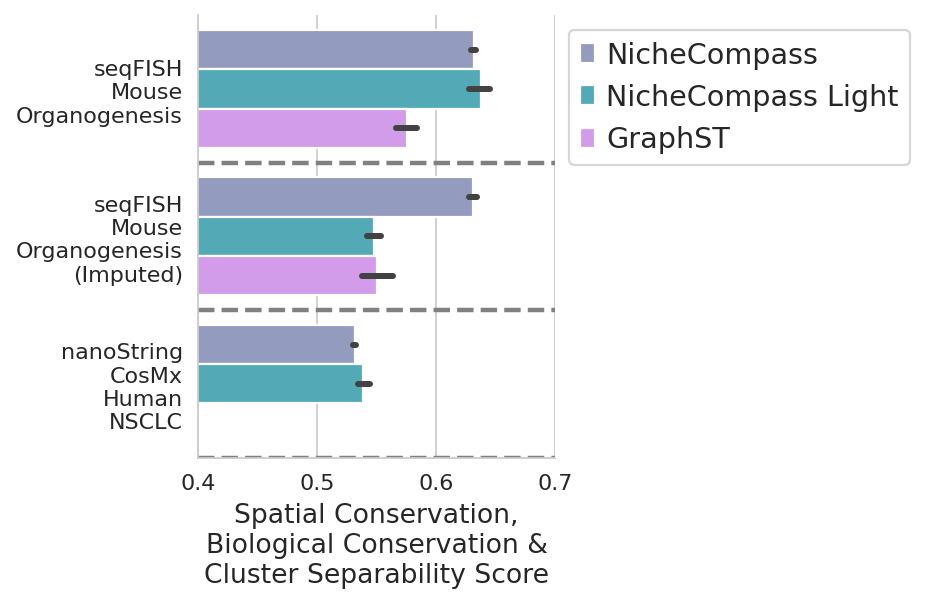

In [168]:
sns.set_style("whitegrid")

summary_df["Spatial Conservation, Biological Conservation & Cluster Separability Score"] = summary_df[["Spatial Conservation Score",
                                                                                                       "Biological Conservation Score",
                                                                                                       "Cluster Separability Score"]].mean(axis=1)

model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "GraphST": "#D78FF8"}

plt.figure(figsize=(6, 4))
ax = sns.barplot(data=summary_df,
                 x="Spatial Conservation, Biological Conservation & Cluster Separability Score",
                 y="dataset",
                 hue="model",
                 orient="h",
                 palette=model_palette
                )
for i in range(summary_df["dataset"].nunique()):
    ax.axhline(0.5 + 1 * i, color='gray', linestyle='--', linewidth=2)

new_labels = [label.get_text().replace(' ', '\n') if i < 3 else label.get_text().replace(' H', '\nH', -1).replace(' N', '\nN', -1) for i, label in enumerate(ax.get_yticklabels())]
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticklabels(new_labels)
plt.ylabel(None)
plt.xlabel("Spatial Conservation,\nBiological Conservation &\nCluster Separability Score", fontsize=12)
plt.yticks(fontsize=10)
plt.xticks([0.4, 0.5, 0.6, 0.7], fontsize=10)
plt.xlim(0.4, 0.7)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f"{benchmarking_folder_path}/benchmarking_barplot_non_batch_correction_scores.svg")
plt.show()

/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


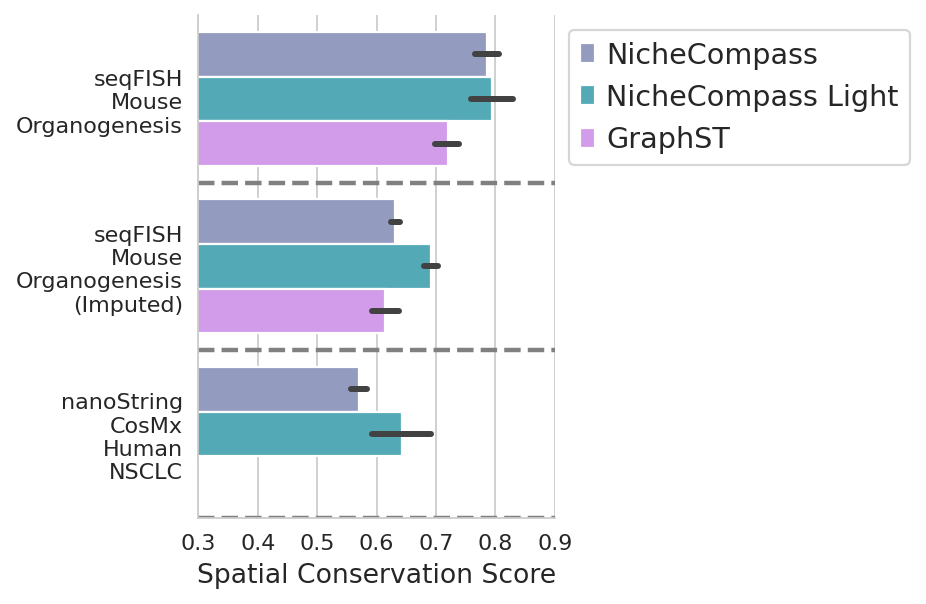

In [169]:
sns.set_style("whitegrid")

model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "GraphST": "#D78FF8"}

plt.figure(figsize=(6, 4))
ax = sns.barplot(data=summary_df,
                 x="Spatial Conservation Score",
                 y="dataset",
                 hue="model",
                 orient="h",
                 palette=model_palette
                )
for i in range(summary_df["dataset"].nunique()):
    ax.axhline(0.5 + 1 * i, color='gray', linestyle='--', linewidth=2)

new_labels = [label.get_text().replace(' ', '\n') if i < 3 else label.get_text().replace(' H', '\nH', -1).replace(' N', '\nN', -1) for i, label in enumerate(ax.get_yticklabels())]
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticklabels(new_labels)
plt.ylabel(None)
plt.xlabel("Spatial Conservation Score", fontsize=12)
plt.yticks(fontsize=10)
plt.xticks([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], fontsize=10)
plt.xlim(0.3, 0.9)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f"{benchmarking_folder_path}/benchmarking_barplot_spatial_conservation_score.svg")
plt.show()

/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


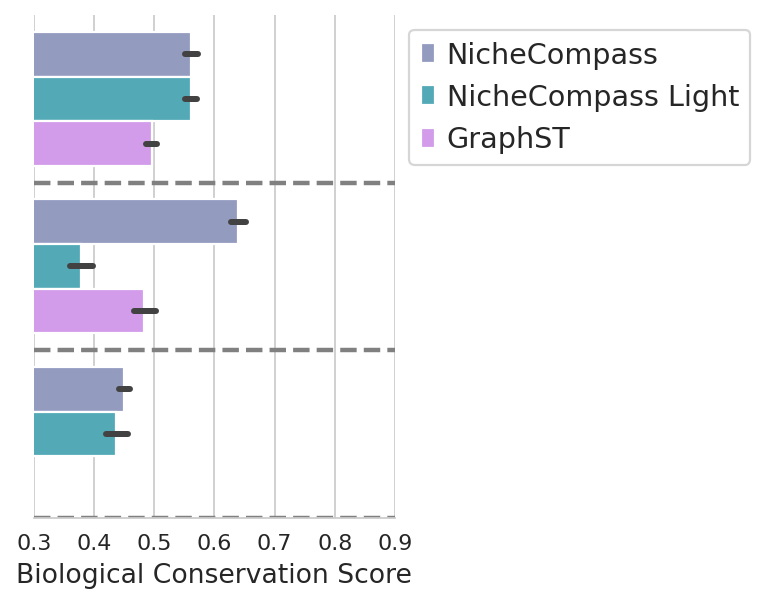

In [170]:
sns.set_style("whitegrid")

model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "GraphST": "#D78FF8",
                 }

plt.figure(figsize=(5, 4))
ax = sns.barplot(data=summary_df,
                 x="Biological Conservation Score",
                 y="dataset",
                 hue="model",
                 orient="h",
                 palette=model_palette)
for i in range(summary_df["dataset"].nunique()):
    ax.axhline(0.5 + 1 * i, color='gray', linestyle='--', linewidth=2)

new_labels = [label.get_text().replace(' ', '\n', 1) if i < 3 else label.get_text().replace(' H', '\nH', -1) for i, label in enumerate(ax.get_yticklabels())]
ax.set_yticklabels(new_labels)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.ylabel(None)
plt.xlabel("Biological Conservation Score", fontsize=12)
plt.yticks([])
plt.xticks([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], fontsize=10)
plt.xlim(0.3, 0.9)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f"{benchmarking_folder_path}/benchmarking_barplot_biological_conservation_score.svg")
plt.show()

/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


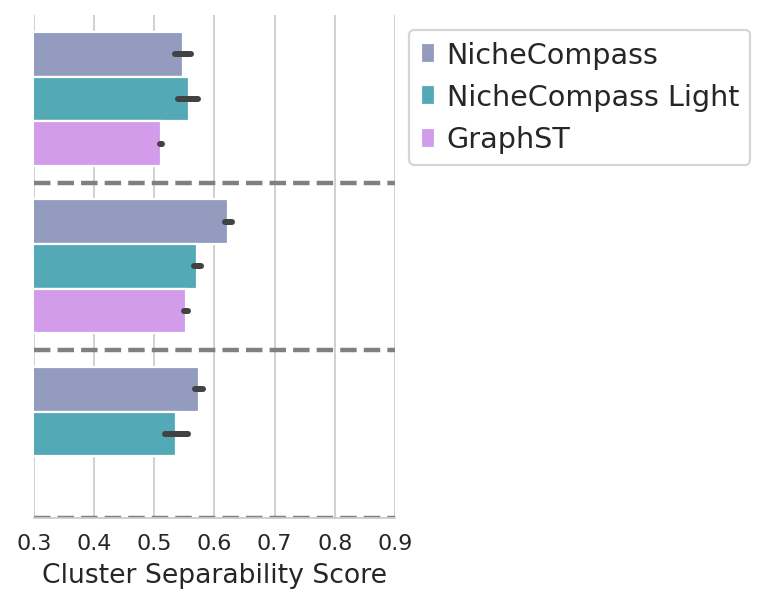

In [171]:
sns.set_style("whitegrid")

model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "GraphST": "#D78FF8",
                 }

plt.figure(figsize=(5, 4))
ax = sns.barplot(data=summary_df,
                 x="Cluster Separability Score",
                 y="dataset",
                 hue="model",
                 orient="h",
                 palette=model_palette)
for i in range(summary_df["dataset"].nunique()):
    ax.axhline(0.5 + 1 * i, color='gray', linestyle='--', linewidth=2)

new_labels = [label.get_text().replace(' ', '\n', 1) if i < 3 else label.get_text().replace(' H', '\nH', -1) for i, label in enumerate(ax.get_yticklabels())]
ax.set_yticklabels(new_labels)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.ylabel(None)
plt.xlabel("Cluster Separability Score", fontsize=12)
plt.yticks([])
plt.xticks([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], fontsize=10)
plt.xlim(0.3, 0.9)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f"{benchmarking_folder_path}/benchmarking_barplot_cluster_separability_score.svg")
plt.show()

/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


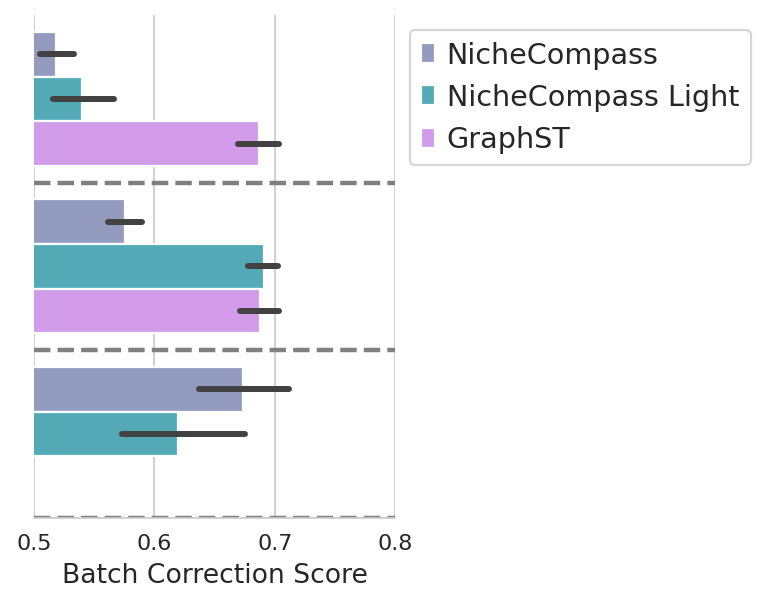

In [175]:
sns.set_style("whitegrid")

model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "GraphST": "#D78FF8",
                 }

plt.figure(figsize=(5, 4))
ax = sns.barplot(data=summary_df,
                 x="Batch Correction Score",
                 y="dataset",
                 hue="model",
                 orient="h",
                 palette=model_palette)
for i in range(summary_df["dataset"].nunique()):
    ax.axhline(0.5 + 1 * i, color='gray', linestyle='--', linewidth=2)

new_labels = [label.get_text().replace(' ', '\n', 1) if i < 3 else label.get_text().replace(' H', '\nH', -1) for i, label in enumerate(ax.get_yticklabels())]
ax.set_yticklabels(new_labels)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.ylabel(None)
plt.xlabel("Batch Correction Score", fontsize=12)
plt.yticks([])
plt.xticks([0.5, 0.6, 0.7, 0.8], fontsize=10)
plt.xlim(0.5, 0.8)
plt.xticks(fontsize=10)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f"{benchmarking_folder_path}/benchmarking_barplot_batch_correction_score.svg")
plt.show()

/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


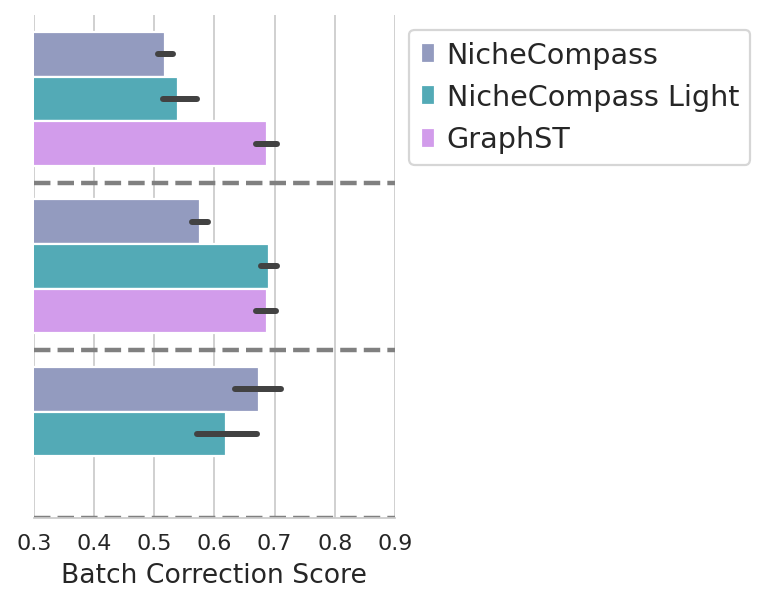

In [173]:
sns.set_style("whitegrid")

model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "GraphST": "#D78FF8",
                 }

plt.figure(figsize=(5, 4))
ax = sns.barplot(data=summary_df,
                 x="Batch Correction Score",
                 y="dataset",
                 hue="model",
                 orient="h",
                 palette=model_palette)
for i in range(summary_df["dataset"].nunique()):
    ax.axhline(0.5 + 1 * i, color='gray', linestyle='--', linewidth=2)

new_labels = [label.get_text().replace(' ', '\n', 1) if i < 3 else label.get_text().replace(' H', '\nH', -1) for i, label in enumerate(ax.get_yticklabels())]
ax.set_yticklabels(new_labels)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.ylabel(None)
plt.xlabel("Batch Correction Score", fontsize=12)
plt.yticks([])
plt.xticks([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], fontsize=10)
plt.xlim(0.3, 0.9)
plt.xticks(fontsize=10)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f"{benchmarking_folder_path}/benchmarking_barplot_batch_correction_score2.svg")
plt.show()

/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


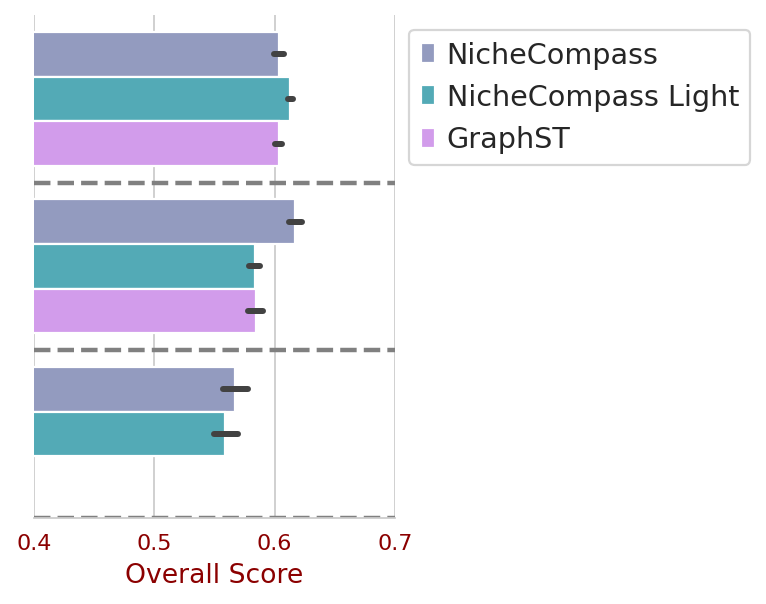

In [174]:
sns.set_style("whitegrid")

model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "GraphST": "#D78FF8",
                 }

plt.figure(figsize=(5, 4))
ax = sns.barplot(data=summary_df,
                 x="Overall Score",
                 y="dataset",
                 hue="model",
                 orient="h",
                 palette=model_palette
                )
for i in range(summary_df["dataset"].nunique()):
    ax.axhline(0.5 + 1 * i, color='gray', linestyle='--', linewidth=2)

new_labels = [label.get_text().replace(' ', '\n', 1) if i < 3 else label.get_text().replace(' H', '\nH', -1) for i, label in enumerate(ax.get_yticklabels())]
ax.set_yticklabels(new_labels)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.ylabel(None)
plt.xlabel("Overall Score", fontsize=12, color="darkred")
plt.yticks([])
plt.xticks([0.4, 0.5, 0.6, 0.7], fontsize=10, color="darkred")
plt.xlim(0.4, 0.7)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f"{benchmarking_folder_path}/benchmarking_barplot_overall_score.svg")
plt.show()

### 2.2 Method Comparison Visualizations

#### 2.1.1 nanoString CosMx SMI Human Non-Small-Cell Lung Cancer (NSCLC)

In [14]:
sns.color_palette("colorblind").as_hex()

['#0173b2',
 '#de8f05',
 '#029e73',
 '#d55e00',
 '#cc78bc',
 '#ca9161',
 '#fbafe4',
 '#949494',
 '#ece133',
 '#56b4e9']

In [11]:
print(sns.color_palette("colorblind").as_hex())

['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc', '#ca9161', '#fbafe4', '#949494', '#ece133', '#56b4e9']


##### 2.1.1.1 10 Percent Subsample

In [ ]:
### Main figure: 10 pct subsample comparison NC vs GraphST ###
# NicheCompass (fov embedding)
dataset = "nanostring_cosmx_human_nsclc_subsample_10pct"
run_number = 2
model = "nichecompass_gatv2conv"
latent_leiden_resolution = 0.21
timestamp = "26082023_191240_1" # "02092023_171351_1"
adata = sc.read_h5ad(f"{artifact_folder_path}/{dataset}/models/gatv2conv_sample_integration_method_benchmarking/{timestamp}/run{run_number}/{dataset}_gatv2conv_sample_integration_method_benchmarking.h5ad")

print("\nComputing UMAP embedding...")
sc.tl.umap(adata,
           neighbors_key=f"nichecompass_latent")

print("\nComputing Leiden clustering...")
sc.tl.leiden(adata=adata,
             resolution=latent_leiden_resolution,
             key_added=f"latent_leiden_{latent_leiden_resolution}",
             neighbors_key=f"nichecompass_latent")

niche_annotation_dict = {
    "0": "Endothelial/Stroma",
    "1": "Tumor 1",
    "2": "Lymphoid Structures",
    "3": "Epithelial/Stroma",
    "4": "Neutrophil/Myeloid/Stroma",
    "5": "Plasmablast/Stroma",
    "6": "Tumor-Stroma Boundary",
    "7": "Tumor 2"}

latent_cluster_colors = create_new_color_dict(
    adata=adata,
    cat_key=f"latent_leiden_{latent_leiden_resolution}")

adata.obs["niche"] = adata.obs[f"latent_leiden_{latent_leiden_resolution}"].map(niche_annotation_dict)
niche_colors = {niche: latent_cluster_colors[cluster] for cluster, niche in niche_annotation_dict.items()}

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Niches",
        model_label={model},
        cat_key="niche",
        groups=None,
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=niche_colors,
        size=(720000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/{dataset}_niches_{model}.svg")

adata.obs["batch"] = adata.obs["batch"].replace({"lung5_rep1": "Replicate 1",
                                                 "lung5_rep2": "Replicate 2",
                                                 "lung5_rep3": "Replicate 3"})

batch_colors = {"Replicate 1": sns.color_palette("colorblind").as_hex()[0],
                "Replicate 2": sns.color_palette("colorblind").as_hex()[3],
                "Replicate 3": sns.color_palette("colorblind").as_hex()[8]}

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Batches",
        model_label={model},
        cat_key="batch",
        groups=None,
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=batch_colors,
        size=(720000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/{dataset}_batches_{model}.svg")

# GraphST with prior alignment through PASTE algorithm
model = "graphst_paste"
latent_leiden_resolution = 0.4
adata = sc.read_h5ad(f"{artifact_folder_path}/sample_integration_method_benchmarking/{dataset}_{model}.h5ad")

print("\nComputing UMAP embedding...")
sc.tl.umap(adata,
           neighbors_key=f"graphst_latent_run{run_number}")

print("\nComputing Leiden clustering...")
sc.tl.leiden(adata=adata,
             resolution=latent_leiden_resolution,
             key_added=f"latent_leiden_{latent_leiden_resolution}",
             neighbors_key=f"graphst_latent_run{run_number}")

latent_cluster_colors = {
    "0": "#66C5CC",
    "1": "#9EB9F3",
    "2": "#C9DB74",
    "3": "#DCB0F2",
    "4": "#8B008B",
    "5": "#FE88B1",
    "6": "#87C55F",
    "7": "#F89C74"}

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Niches",
        model_label={model},
        cat_key=f"latent_leiden_{latent_leiden_resolution}",
        groups=None,
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=latent_cluster_colors,
        size=(720000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/{dataset}_niches_{model}.svg")

adata.obs["batch"] = adata.obs["batch"].replace({"lung5_rep1": "Replicate 1",
                                                 "lung5_rep2": "Replicate 2",
                                                 "lung5_rep3": "Replicate 3"})

batch_colors = {"Replicate 1": sns.color_palette("colorblind").as_hex()[0],
                "Replicate 2": sns.color_palette("colorblind").as_hex()[3],
                "Replicate 3": sns.color_palette("colorblind").as_hex()[8]}

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Batches",
        model_label={model},
        cat_key="batch",
        groups=None,
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=batch_colors,
        size=(720000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/{dataset}_batches_{model}.svg")


Computing UMAP embedding...

Computing Leiden clustering...


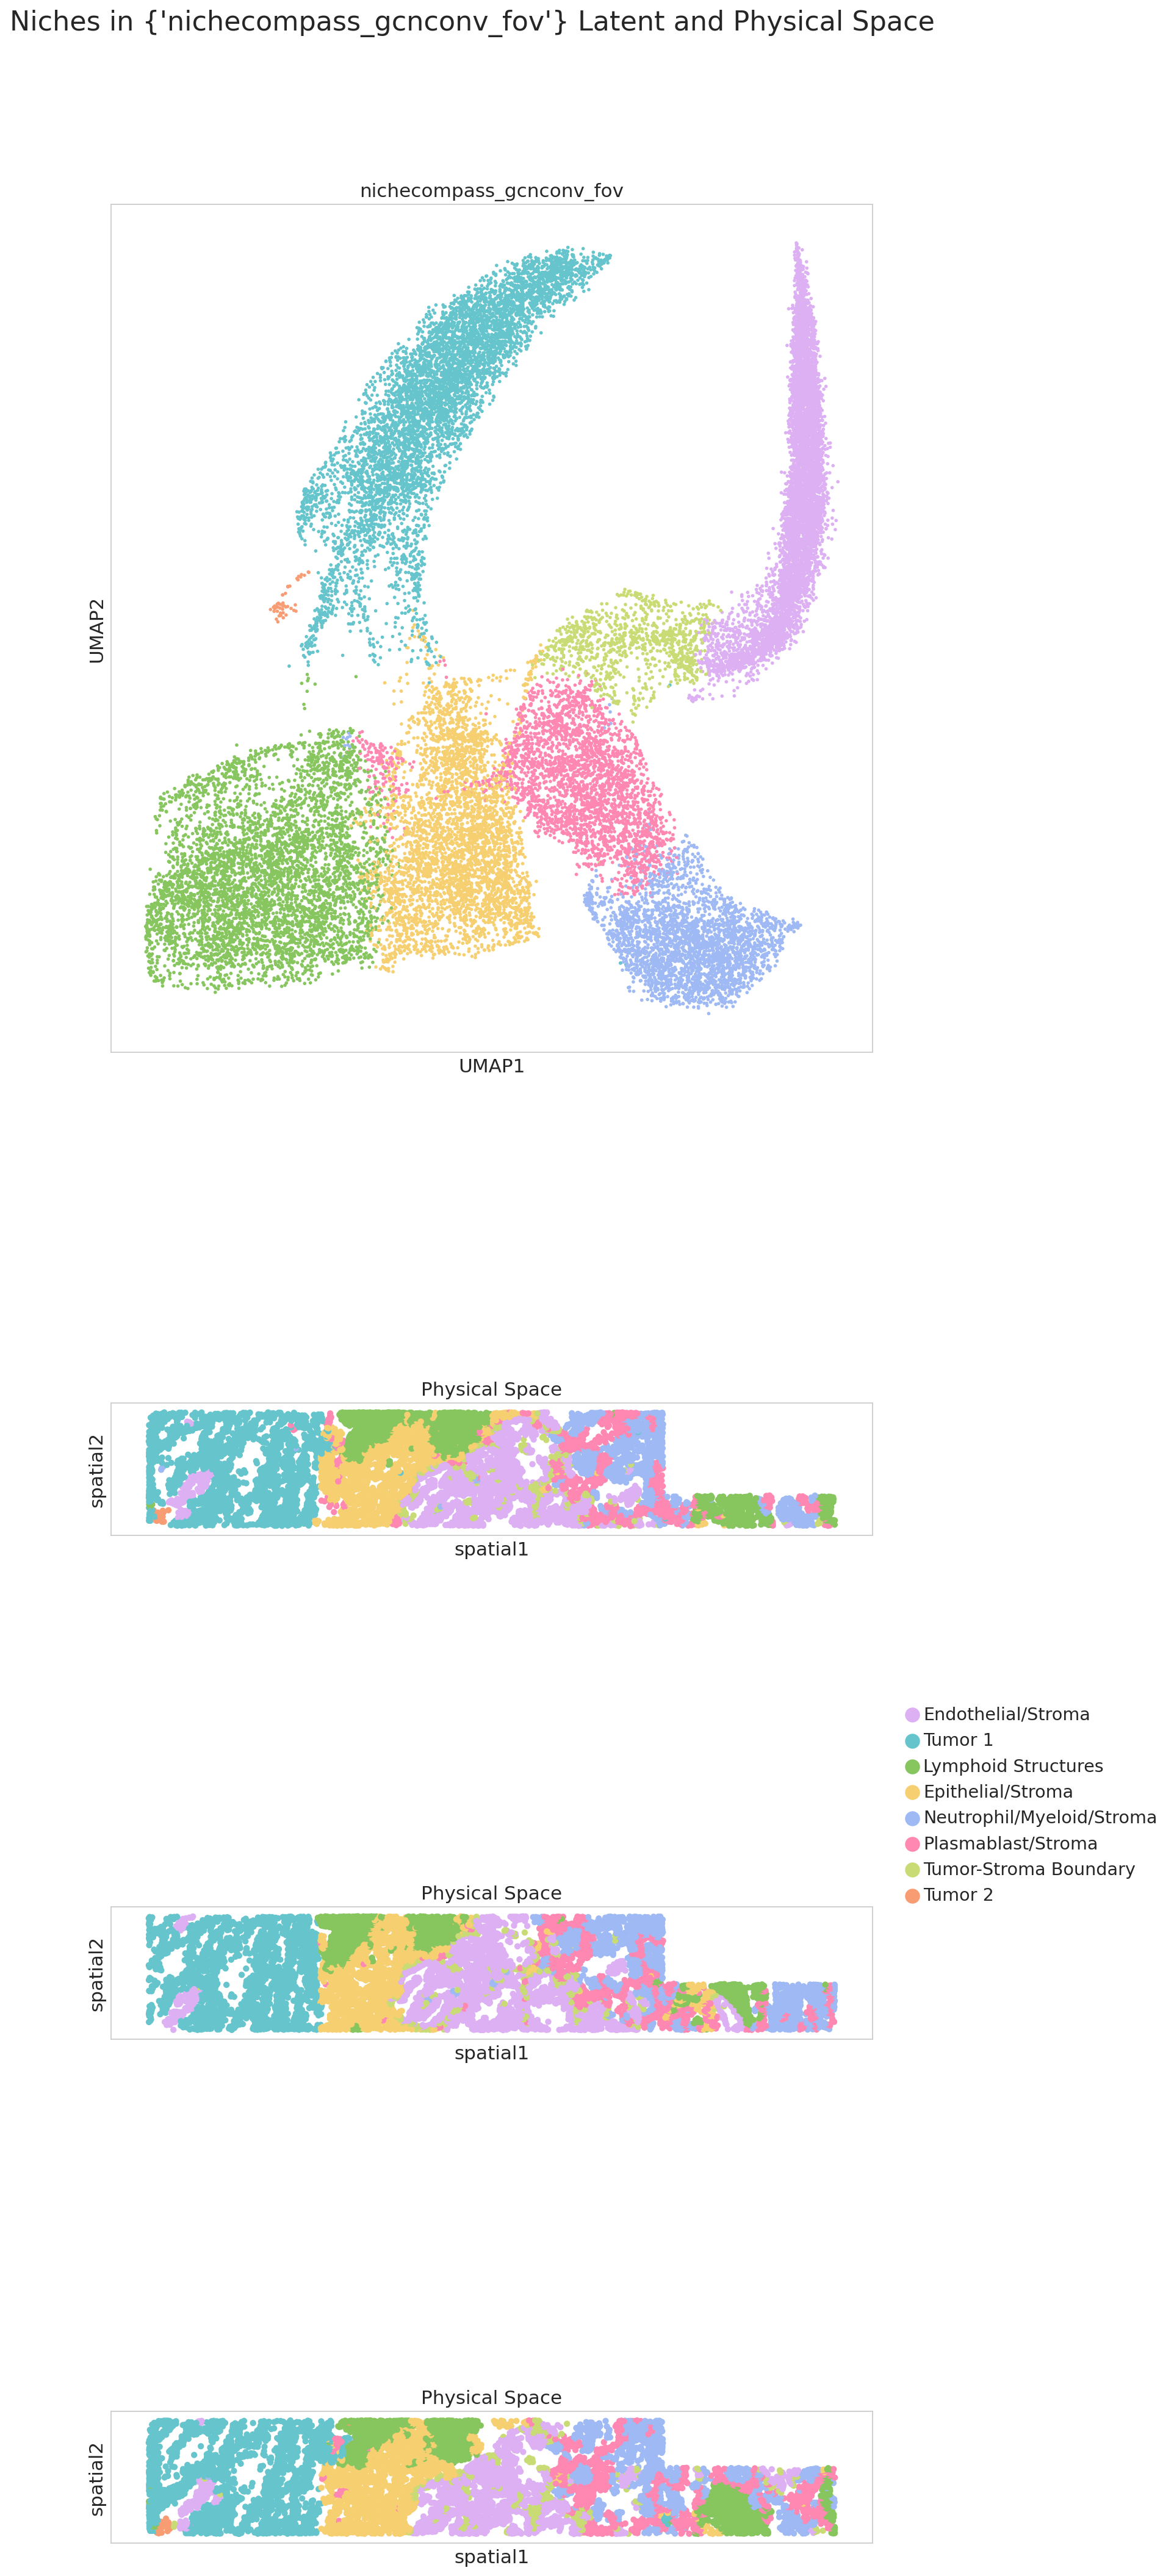

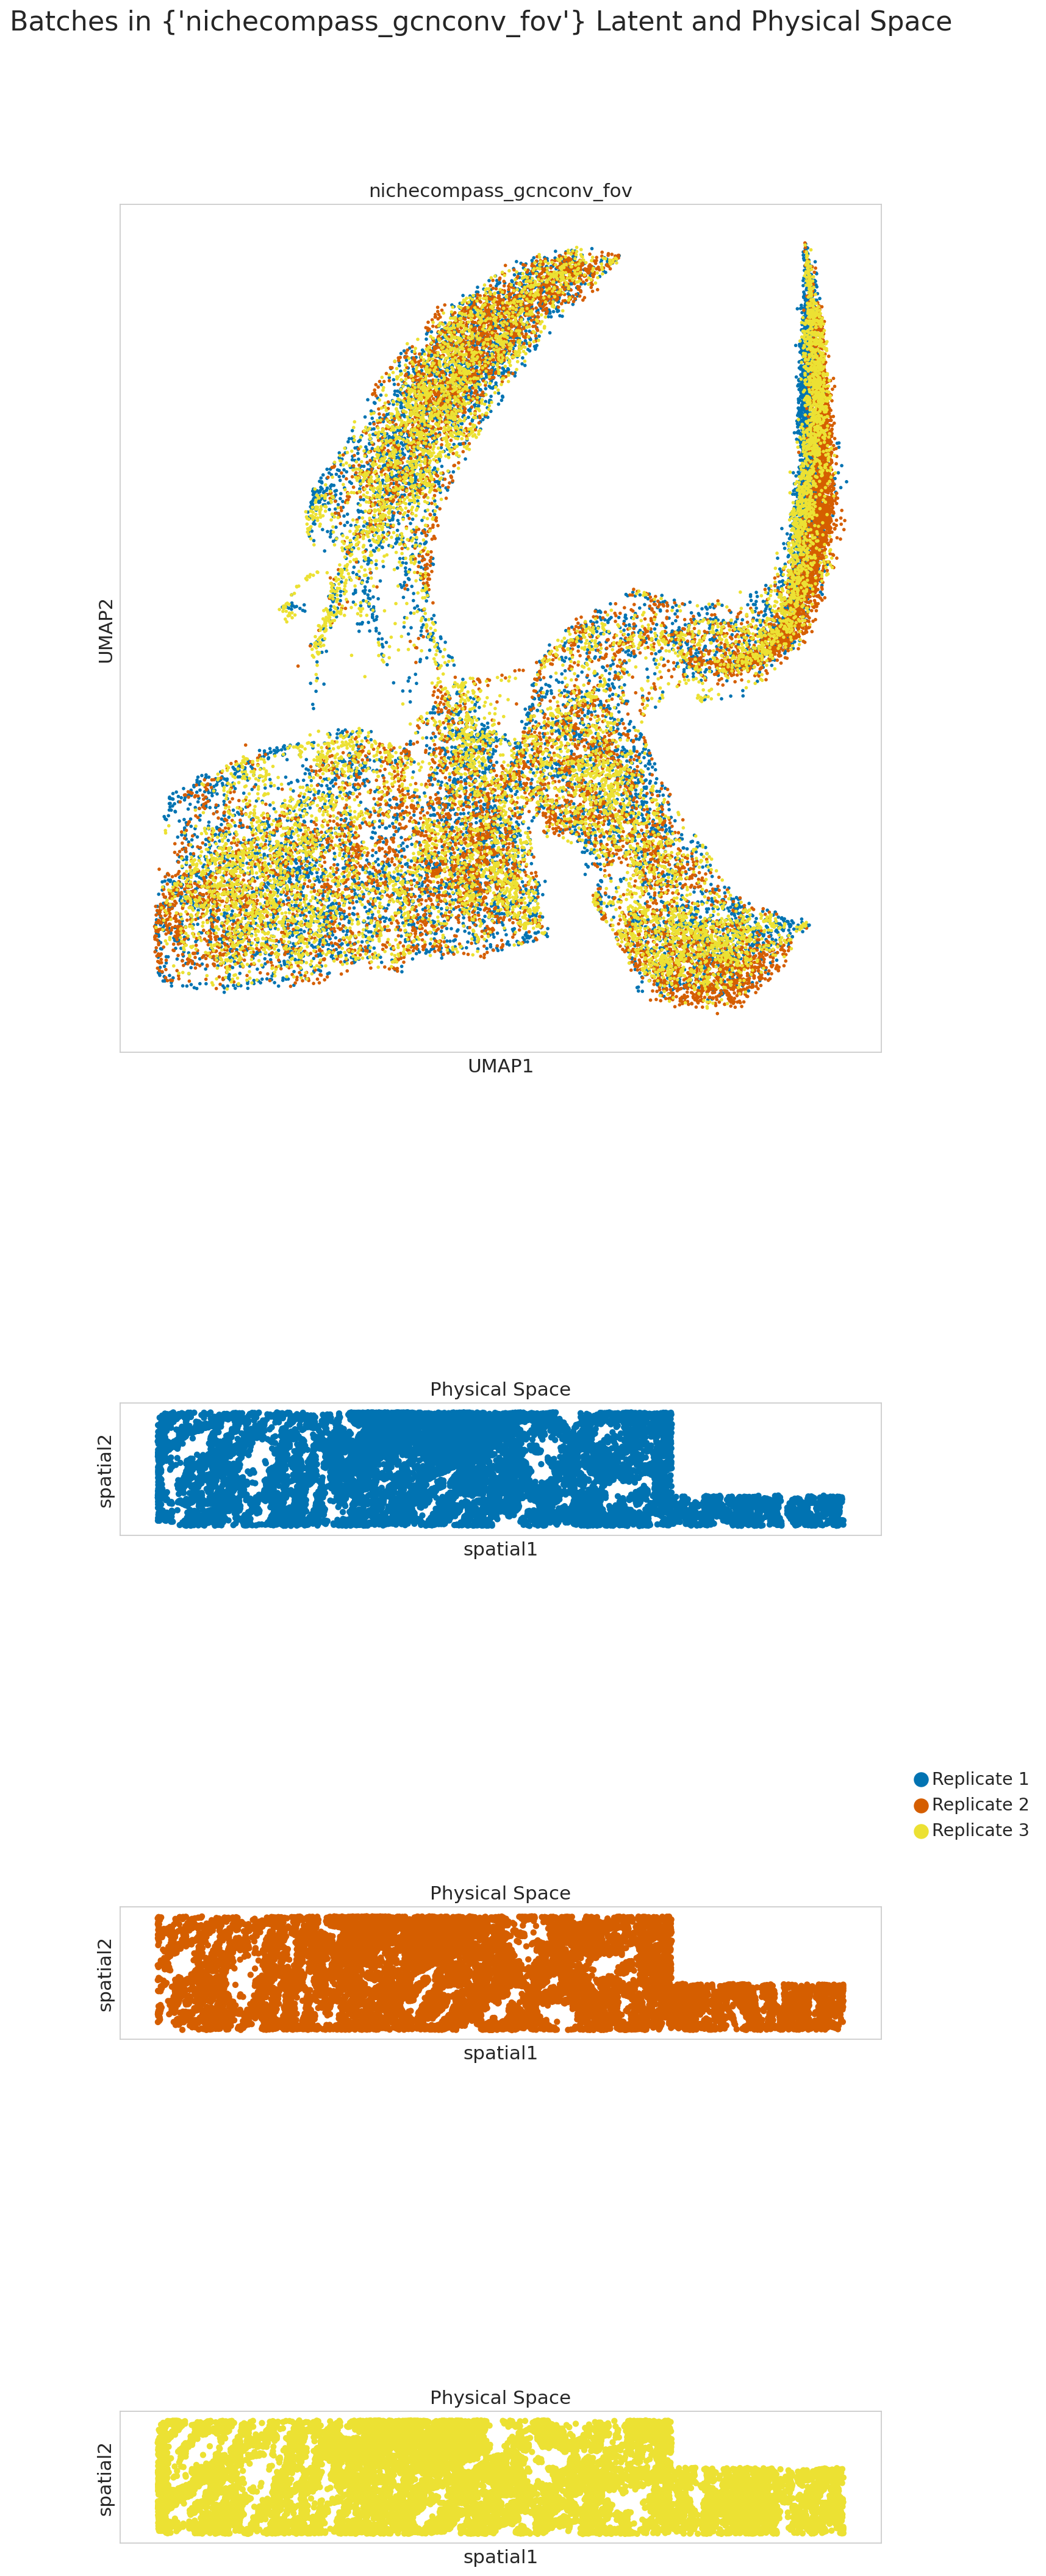

In [57]:
# NicheCompass (cont loss)
dataset = "nanostring_cosmx_human_nsclc_subsample_10pct"
run_number = 2
model = "nichecompass_gcnconv_fov"
latent_leiden_resolution = 0.
timestamp = "02092023_171351_1"
adata = sc.read_h5ad(f"{artifact_folder_path}/{dataset}/models/gatv2conv_sample_integration_method_benchmarking/{timestamp}/run{run_number}/{dataset}_gatv2conv_sample_integration_method_benchmarking.h5ad")

print("\nComputing UMAP embedding...")
sc.tl.umap(adata,
           neighbors_key=f"nichecompass_latent")

print("\nComputing Leiden clustering...")
sc.tl.leiden(adata=adata,
             resolution=latent_leiden_resolution,
             key_added=f"latent_leiden_{latent_leiden_resolution}",
             neighbors_key=f"nichecompass_latent")

niche_annotation_dict = {
    "0": "Endothelial/Stroma",
    "1": "Tumor 1",
    "2": "Lymphoid Structures",
    "3": "Epithelial/Stroma",
    "4": "Neutrophil/Myeloid/Stroma",
    "5": "Plasmablast/Stroma",
    "6": "Tumor-Stroma Boundary",
    "7": "Tumor 2"}

latent_cluster_colors = create_new_color_dict(
    adata=adata,
    cat_key=f"latent_leiden_{latent_leiden_resolution}")

adata.obs["niche"] = adata.obs[f"latent_leiden_{latent_leiden_resolution}"].map(niche_annotation_dict)
niche_colors = {niche: latent_cluster_colors[cluster] for cluster, niche in niche_annotation_dict.items()}

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Niches",
        model_label={model},
        cat_key="niche",
        groups=None,
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=niche_colors,
        size=(720000 / len(adata)),
        spot_size=200,
        save_fig=False,
        file_path=f"{benchmarking_folder_path}/{dataset}_niches_{model}.svg")

adata.obs["batch"] = adata.obs["batch"].replace({"lung5_rep1": "Replicate 1",
                                                 "lung5_rep2": "Replicate 2",
                                                 "lung5_rep3": "Replicate 3"})

batch_colors = {"Replicate 1": sns.color_palette("colorblind").as_hex()[0],
                "Replicate 2": sns.color_palette("colorblind").as_hex()[3],
                "Replicate 3": sns.color_palette("colorblind").as_hex()[8]}

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Batches",
        model_label={model},
        cat_key="batch",
        groups=None,
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=batch_colors,
        size=(720000 / len(adata)),
        spot_size=200,
        save_fig=False,
        file_path=f"{benchmarking_folder_path}/{dataset}_batches_{model}.svg")

In [ ]:
### Supplementary figure: 10 pct subsample comparison NC vs GraphST ###
# GraphST without prior alignment through PASTE algorithm
model = "graphst"
latent_leiden_resolution = 0.35
adata = sc.read_h5ad(f"{artifact_folder_path}/sample_integration_method_benchmarking/{dataset}_{model}.h5ad")

print("\nComputing UMAP embedding...")
sc.tl.umap(adata,
           neighbors_key=f"graphst_latent_run{run_number}")

print("\nComputing Leiden clustering...")
sc.tl.leiden(adata=adata,
             resolution=latent_leiden_resolution,
             key_added=f"latent_leiden_{latent_leiden_resolution}",
             neighbors_key=f"graphst_latent_run{run_number}")

latent_cluster_colors = {
    "0": "#66C5CC",
    "1": "#9EB9F3",
    "2": "#C9DB74",
    "3": "#FE88B1",
    "4": "#DCB0F2",
    "5": "#8B008B",
    "6": "#F89C74",
    "7": "#C0C0C0"}

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Niches",
        model_label={model},
        cat_key=f"latent_leiden_{latent_leiden_resolution}",
        groups=None,
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=latent_cluster_colors,
        size=(720000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/{dataset}_niches_{model}.svg")

adata.obs["batch"] = adata.obs["batch"].replace({"lung5_rep1": "Replicate 1",
                                                 "lung5_rep2": "Replicate 2",
                                                 "lung5_rep3": "Replicate 3"})

batch_colors = {"Replicate 1": sns.color_palette("colorblind").as_hex()[0],
                "Replicate 2": sns.color_palette("colorblind").as_hex()[3],
                "Replicate 3": sns.color_palette("colorblind").as_hex()[5]}

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Batches",
        model_label={model},
        cat_key="batch",
        groups=None,
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=batch_colors,
        size=(720000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/{dataset}_batches_{model}.svg")

In [ ]:
# NicheCompass (no fov embedding)
model = "nichecompass_gatv2conv"
timestamp = "24082023_153432_1"
latent_leiden_resolution = 0.21
adata = sc.read_h5ad(f"{artifact_folder_path}/{dataset}/models/gatv2conv_sample_integration_method_benchmarking/{timestamp}/run{run_number}/{dataset}_gatv2conv_sample_integration_method_benchmarking.h5ad")

print("\nComputing UMAP embedding...")
sc.tl.umap(adata,
           neighbors_key=f"nichecompass_latent")

print("\nComputing Leiden clustering...")
sc.tl.leiden(adata=adata,
             resolution=latent_leiden_resolution,
             key_added=f"latent_leiden_{latent_leiden_resolution}",
             neighbors_key=f"nichecompass_latent")

latent_cluster_colors = {
    "0": "#9EB9F3",
    "1": "#C9DB74",
    "2": "#87C55F",
    "3": "#66C5CC",
    "4": "#FE88B1",
    "5": "#DCB0F2",
    "6": "#8B008B",
    "7": "#F89C74"}

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Niches",
        model_label={model},
        cat_key=f"latent_leiden_{latent_leiden_resolution}",
        groups=None,
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=latent_cluster_colors,
        size=(720000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/{dataset}_niches_{model}.svg")

adata.obs["batch"] = adata.obs["batch"].replace({"lung5_rep1": "Replicate 1",
                                                 "lung5_rep2": "Replicate 2",
                                                 "lung5_rep3": "Replicate 3"})

batch_colors = create_new_color_dict(
    adata=adata,
    cat_key="batch")

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Batches",
        model_label={model},
        cat_key="batch",
        groups=None,
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=batch_colors,
        size=(720000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/{dataset}_batches_{model}.svg")

##### 2.1.1.2 Full Dataset

In [ ]:
adata = sc.read_h5ad(f"../../artifacts/nanostring_cosmx_human_nsclc/models/gatv2conv_sample_integration_method_benchmarking/29082023_164105_17/run2/nanostring_cosmx_human_nsclc_gatv2conv_sample_integration_method_benchmarking.h5ad")
model = "nichecompass_gatv2conv"
latent_leiden_resolution = 0.5

print("\nComputing UMAP embedding...")
sc.tl.umap(adata,
           neighbors_key=f"nichecompass_latent")

print("\nComputing Leiden clustering...")
sc.tl.leiden(adata=adata,
             resolution=latent_leiden_resolution,
             key_added=f"latent_leiden_{latent_leiden_resolution}",
             neighbors_key=f"nichecompass_latent")

latent_cluster_colors = create_new_color_dict(
    adata=adata,
    cat_key=f"latent_leiden_{latent_leiden_resolution}")

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Latent Clusters",
        model_label={model},
        cat_key=f"latent_leiden_{latent_leiden_resolution}",
        groups=None,
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=latent_cluster_colors,
        size=(720000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/nanostring_cosmx_human_nsclc_latent_clusters_{model}.svg")

In [ ]:
latent_cluster_colors = create_new_color_dict(
    adata=adata,
    cat_key=f"latent_leiden_{latent_leiden_resolution}")

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Latent Clusters",
        model_label={model},
        cat_key=f"latent_leiden_{latent_leiden_resolution}",
        groups=None,
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=latent_cluster_colors,
        size=(720000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/nanostring_cosmx_human_nsclc_latent_clusters_{model}.svg")

In [ ]:
# NicheCompass (with fov embedding)
adata = sc.read_h5ad(f"../../artifacts/nanostring_cosmx_human_nsclc/models/gatv2conv_sample_integration_method_benchmarking/23082023_210907_6/run2/nanostring_cosmx_human_nsclc_gatv2conv_sample_integration_method_benchmarking.h5ad")
model = "nichecompass_gatv2conv"
latent_leiden_resolution = 0.5

print("\nComputing UMAP embedding...")
sc.tl.umap(adata,
           neighbors_key=f"nichecompass_latent")

print("\nComputing Leiden clustering...")
sc.tl.leiden(adata=adata,
             resolution=latent_leiden_resolution,
             key_added=f"latent_leiden_{latent_leiden_resolution}",
             neighbors_key=f"nichecompass_latent")

latent_cluster_colors = create_new_color_dict(
    adata=adata,
    cat_key=f"latent_leiden_{latent_leiden_resolution}")

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Latent Clusters",
        model_label={model},
        cat_key=f"latent_leiden_{latent_leiden_resolution}",
        groups=None,
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=latent_cluster_colors,
        size=(720000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/nanostring_cosmx_human_nsclc_latent_clusters_{model}.svg")

In [ ]:
# NicheCompass (with fov embedding)
adata = sc.read_h5ad(f"../../artifacts/nanostring_cosmx_human_nsclc/models/gatv2conv_sample_integration_method_benchmarking/23082023_210907_6/run2/nanostring_cosmx_human_nsclc_gatv2conv_sample_integration_method_benchmarking.h5ad")
model = "nichecompass_gatv2conv"
latent_leiden_resolution = 0.5

print("\nComputing UMAP embedding...")
sc.tl.umap(adata,
           neighbors_key=f"nichecompass_latent")

print("\nComputing Leiden clustering...")
sc.tl.leiden(adata=adata,
             resolution=latent_leiden_resolution,
             key_added=f"latent_leiden_{latent_leiden_resolution}",
             neighbors_key=f"nichecompass_latent")

latent_cluster_colors = create_new_color_dict(
    adata=adata,
    cat_key=f"latent_leiden_{latent_leiden_resolution}")

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Latent Clusters",
        model_label={model},
        cat_key=f"latent_leiden_{latent_leiden_resolution}",
        groups=None,
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=latent_cluster_colors,
        size=(720000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/nanostring_cosmx_human_nsclc_latent_clusters_{model}.svg")

In [ ]:
adata = sc.read_h5ad("../../artifacts/sample_integration_method_benchmarking/nanostring_cosmx_human_nsclc_reference.h5ad")

In [ ]:
adata.obs["leiden_0.5"]

In [ ]:
latent_cluster_colors = create_new_color_dict(
    adata=adata,
    cat_key=f"leiden_{latent_leiden_resolution}")

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Latent Clusters",
        model_label={model},
        cat_key=f"leiden_{latent_leiden_resolution}",
        groups=["10", "11"],
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=latent_cluster_colors,
        size=(720000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/nanostring_cosmx_human_nsclc_latent_clusters_{model}.svg")

In [ ]:
sc.pl.umap(adata, color="batch")

In [ ]:
sc.pl.umap(adata, color="leiden_0.5")

In [ ]:
# NicheCompass (without fov embedding)
adata = sc.read_h5ad(f"../../artifacts/nanostring_cosmx_human_nsclc/models/gatv2conv_sample_integration_method_benchmarking/21082023_190305_1/run2/nanostring_cosmx_human_nsclc_gatv2conv_sample_integration_method_benchmarking.h5ad")
model = "nichecompass_gatv2conv"
latent_leiden_resolution = 0.5

print("\nComputing UMAP embedding...")
sc.tl.umap(adata,
           neighbors_key=f"nichecompass_latent")

print("\nComputing Leiden clustering...")
sc.tl.leiden(adata=adata,
             resolution=latent_leiden_resolution,
             key_added=f"latent_leiden_{latent_leiden_resolution}",
             neighbors_key=f"nichecompass_latent")

latent_cluster_colors = create_new_color_dict(
    adata=adata,
    cat_key=f"latent_leiden_{latent_leiden_resolution}")

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Latent Clusters",
        model_label={model},
        cat_key=f"latent_leiden_{latent_leiden_resolution}",
        groups=None,
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=latent_cluster_colors,
        size=(720000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/nanostring_cosmx_human_nsclc_latent_clusters_{model}.svg")

In [ ]:
adata_original_batch1 = sc.read_h5ad("../../datasets/srt_data/gold/nanostring_cosmx_human_nsclc_subsample_10pct_batch1.h5ad")
adata_original_batch2 = sc.read_h5ad("../../datasets/srt_data/gold/nanostring_cosmx_human_nsclc_subsample_10pct_batch2.h5ad")
adata_original_batch3 = sc.read_h5ad("../../datasets/srt_data/gold/nanostring_cosmx_human_nsclc_subsample_10pct_batch3.h5ad")
adata_original = ad.concat([adata_original_batch1, adata_original_batch2, adata_original_batch3], axis=0)
adata_original.obs = adata_original.obs.reset_index(drop=True)

adata.obs = adata.obs.reset_index(drop=True)
adata.obs = adata.obs.merge(adata_original.obs[["niche"]], left_index=True, right_index=True, how='left')

In [ ]:
cell_type_key = "cell_type"

In [ ]:
adata.obs

In [ ]:
cell_type_colors = create_new_color_dict(
    adata=adata,
    cat_key=cell_type_key)

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Cell Types",
        model_label={model},
        cat_key=cell_type_key,
        groups=["endothelial"],
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=cell_type_colors,
        size=(720000 / len(adata)),
        spot_size=200,
        save_fig=False,
        file_path=f"{benchmarking_folder_path}/cell_types_nanostring_cosmx_human_nsclc_subsample_10pct_{model}.svg")

In [ ]:
niche_colors = create_new_color_dict(
    adata=adata,
    cat_key=f"niche")

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Latent Clusters",
        model_label={model},
        cat_key=f"niche",
        groups=None,
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=niche_colors,
        size=(720000 / len(adata)),
        spot_size=200,
        save_fig=False,
        file_path=f"{benchmarking_folder_path}/niches_nanostring_cosmx_human_nsclc_subsample_10pct_{model}.svg")

In [ ]:
batch_colors = create_new_color_dict(
    adata=adata,
    cat_key=f"batch")

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Batches",
        model_label={model},
        cat_key=f"batch",
        groups=None,
        sample_key="batch",
        samples=["lung5_rep1", "lung5_rep2", "lung5_rep3"],
        cat_colors=batch_colors,
        size=(1440000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/batches_nanostring_cosmx_human_nsclc_subsample_10pct_{model}.svg")

In [ ]:
batch_colors = create_new_color_dict(
    adata=adata,
    cat_key=f"batch")

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Latent Clusters",
        model_label={model},
        cat_key=f"batch",
        groups=None,
        sample_key="batch",
        samples=["lung5_rep1", "lung5_rep2", "lung5_rep3"],
        cat_colors=batch_colors,
        size=(1440000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/nanostring_cosmx_human_nsclc_batches_{model}.svg")

In [ ]:
cell_type_colors = create_new_color_dict(
    adata=adata,
    cat_key=f"cell_type")

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Cell Types",
        model_label={model},
        cat_key=f"cell_type",
        groups=None,
        sample_key="batch",
        samples=["lung5_rep1", "lung5_rep2", "lung5_rep3"],
        cat_colors=cell_type_colors,
        size=(720000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/nanostring_cosmx_human_nsclc_cell_types_{model}.svg")

In [ ]:
adata = sc.read_h5ad(f"../../artifacts/sample_integration_method_benchmarking/nanostring_cosmx_human_nsclc_scvi.h5ad")
model="scvi"

print("\nComputing UMAP embedding...")
sc.tl.umap(adata,
           neighbors_key=f"scvi_latent_run2")

print("\nComputing Leiden clustering...")
sc.tl.leiden(adata=adata,
             resolution=0.78,
             key_added=f"leiden_0.78",
             neighbors_key=f"scvi_latent_run2")

latent_cluster_colors = create_new_color_dict(
    adata=adata,
    cat_key=f"leiden_0.78")

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Latent Clusters",
        model_label={model},
        cat_key=f"leiden_0.78",
        groups=None,
        sample_key="batch",
        samples=["lung5_rep1", "lung5_rep2", "lung5_rep3"],
        cat_colors=latent_cluster_colors,
        size=(720000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/nanostring_cosmx_human_nsclc_latent_clusters_{model}.svg")

In [ ]:
batch_colors = create_new_color_dict(
    adata=adata,
    cat_key=f"batch")

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Latent Clusters",
        model_label={model},
        cat_key=f"batch",
        groups=None,
        sample_key="batch",
        samples=["lung5_rep1", "lung5_rep2", "lung5_rep3"],
        cat_colors=batch_colors,
        size=(1440000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/nanostring_cosmx_human_nsclc_batches_{model}.svg")

In [ ]:
adata = sc.read_h5ad(f"../../artifacts/visium_mouse_brain/models/gatv2conv_sample_integration_method_benchmarking/29082023_171758_1/run2/visium_mouse_brain_gatv2conv_sample_integration_method_benchmarking.h5ad")

In [ ]:
adata = sc.read_h5ad(f"../../artifacts/visium_mouse_brain_anterior/models/gatv2conv_sample_integration_method_benchmarking/29082023_160247_1/run2/visium_mouse_brain_anterior_gatv2conv_sample_integration_method_benchmarking.h5ad")

In [ ]:
adata = sc.read_h5ad(f"../../artifacts/visium_mouse_brain_posterior/models/gatv2conv_sample_integration_method_benchmarking/29082023_160247_2/run2/visium_mouse_brain_posterior_gatv2conv_sample_integration_method_benchmarking.h5ad")

In [ ]:
model = "nichecompass_gatv2conv"

In [ ]:
    print("\nComputing UMAP embedding...")
    sc.tl.umap(adata,
               neighbors_key=f"nichecompass_latent")
        
    print("\nComputing Leiden clustering...")
    sc.tl.leiden(adata=adata,
                 resolution=0.8,
                 key_added=f"leiden_0.8",
                 neighbors_key=f"nichecompass_latent")
    
    latent_cluster_colors = create_new_color_dict(
        adata=adata,
        cat_key=f"leiden_0.8")
    
    plot_category_in_latent_and_physical_space(
            adata=adata,
            plot_label="Latent Clusters",
            model_label={model},
            cat_key=f"leiden_0.8",
            groups=None,
            sample_key="batch",
            samples=["section1", "section2"],
            cat_colors=latent_cluster_colors,
            size=(720000 / len(adata)),
            spot_size=200,
            save_fig=True,
            file_path=f"{benchmarking_folder_path}/latent_clusters_{model}.svg")

In [ ]:
dataset = "nanostring_cosmx_human_nsclc"
models = ["nichecompass_gatv2conv",
          #"graphst",
          #"sagenet",
          #"deeplinc",
          #"scvi",
          #"expimap"
         ]

run_number = 2
leiden_resolutions = [0.35,
                      #0.93,
                      #0.0775,
                      #1.1,
                      #0.875,
                      #1.55
                     ]

for i, model in enumerate(models):
    adata = sc.read_h5ad(f"../../artifacts/sample_integration_method_benchmarking/{dataset}_{model}.h5ad")
    model = model.replace("_gcnconv", "").replace("_gatv2conv", "")
    
    print("\nComputing neighbor graph...")
    # Use latent representation for UMAP generation
    sc.pp.neighbors(adata,
                    use_rep=f"{model}_latent_run{run_number}",
                    key_added=f"{model}_latent_run{run_number}")

    print("\nComputing UMAP embedding...")
    sc.tl.umap(adata,
               neighbors_key=f"{model}_latent_run{run_number}")
        
    print("\nComputing Leiden clustering...")
    sc.tl.leiden(adata=adata,
                 resolution=leiden_resolutions[i],
                 key_added=f"run{run_number}_leiden_{leiden_resolutions[i]}",
                 neighbors_key=f"{model}_latent_run{run_number}")
    
    latent_cluster_colors = create_new_color_dict(
        adata=adata,
        cat_key=f"run{run_number}_leiden_{leiden_resolutions[i]}")
    
    plot_category_in_latent_and_physical_space(
            adata=adata,
            plot_label="Latent Clusters",
            model_label={model},
            cat_key=f"run{run_number}_leiden_{leiden_resolutions[i]}",
            groups=None,
            sample_key="sample",
            samples=["sample1"],
            cat_colors=latent_cluster_colors,
            size=(720000 / len(adata)),
            spot_size=30,
            save_fig=True,
            file_path=f"{benchmarking_folder_path}/latent_clusters_{model}.svg")

In [ ]:
adata.obs["batch"]

In [ ]:
run_number = 2

In [ ]:
    plot_category_in_latent_and_physical_space(
            adata=adata,
            plot_label="Latent Clusters",
            model_label={model},
            cat_key=f"run{run_number}_leiden_{leiden_resolutions[i]}",
            groups=None,
            sample_key="batch",
            samples=["lung5_rep1", "lung5_rep2", "lung5_rep3"],
            cat_colors=latent_cluster_colors,
            size=(720000 / len(adata)),
            spot_size=100,
            save_fig=True,
            file_path=f"{benchmarking_folder_path}/latent_clusters_{model}.svg")

In [ ]:
dataset = "nanostring_cosmx_human_nsclc"
models = ["nichecompass_gatv2conv_fov",
          #"graphst",
          #"sagenet",
          #"deeplinc",
          #"scvi",
          #"expimap"
         ]

run_number = 2
leiden_resolutions = [0.35,
                      #0.93,
                      #0.0775,
                      #1.1,
                      #0.875,
                      #1.55
                     ]

for i, model in enumerate(models):
    adata = sc.read_h5ad(f"../../artifacts/sample_integration_method_benchmarking/{dataset}_{model}.h5ad")
    model = model.replace("_gcnconv_fov", "").replace("_gatv2conv_fov", "")
    
    print("\nComputing neighbor graph...")
    # Use latent representation for UMAP generation
    sc.pp.neighbors(adata,
                    use_rep=f"{model}_latent_run{run_number}",
                    key_added=f"{model}_latent_run{run_number}")

    print("\nComputing UMAP embedding...")
    sc.tl.umap(adata,
               neighbors_key=f"{model}_latent_run{run_number}")
        
    print("\nComputing Leiden clustering...")
    sc.tl.leiden(adata=adata,
                 resolution=leiden_resolutions[i],
                 key_added=f"run{run_number}_leiden_{leiden_resolutions[i]}",
                 neighbors_key=f"{model}_latent_run{run_number}")
    
    latent_cluster_colors = create_new_color_dict(
        adata=adata,
        cat_key=f"run{run_number}_leiden_{leiden_resolutions[i]}")
    
    plot_category_in_latent_and_physical_space(
            adata=adata,
            plot_label="Latent Clusters",
            model_label={model},
            cat_key=f"run{run_number}_leiden_{leiden_resolutions[i]}",
            groups=None,
            sample_key="batch",
            samples=["lung5_rep1", "lung5_rep2", "lung5_rep3"],
            cat_colors=latent_cluster_colors,
            size=(720000 / len(adata)),
            spot_size=100,
            save_fig=True,
            file_path=f"{benchmarking_folder_path}/latent_clusters_{model}.svg")

In [ ]:
adata.obs["sample"] = 

In [ ]:
adata = sc.read_h5ad("../../datasets/srt_data/gold/visium_mouse_brain_batch1.h5ad")

In [ ]:
adata.obs

In [ ]:
adata2 = sc.read_h5ad("../../datasets/srt_data/gold/visium_mouse_brain_batch2.h5ad")

In [ ]:
adata2 = sc.read_h5ad("../../datasets/srt_data/gold/visium_mouse_brain_batch2.h5ad")
adata2.obs["cell_type"] = "unannotated"
adata2.layers["counts"] = adata2.X
adata2.write("../../datasets/srt_data/gold/visium_mouse_brain_batch2.h5ad")

In [ ]:
adata.obs["in_tissue"]

In [ ]:
adata.obsm["spatial"]

In [ ]:
adata.obsm["spatial"][:, 0]

In [ ]:
adata.X.toarray()

In [ ]:
sq.pl.spatial_scatter(adata, color="in_tissue", shape=None, figsize=(12, 12))  

### STARmap

In [ ]:
adata = sc.read_h5ad("../../artifacts/starmap_plus_mouse_cns/models/gatv2conv_sample_integration_method_benchmarking/30082023_124855_1/run2/starmap_plus_mouse_cns_gatv2conv_sample_integration_method_benchmarking.h5ad")

In [ ]:
model = "nichecompass_gatv2conv"

In [ ]:
cell_type_colors = create_new_color_dict(
    adata=adata,
    cat_key="Main_molecular_cell_type")

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Latent Clusters",
        model_label={model},
        cat_key="Main_molecular_cell_type",
        groups=None,
        sample_key="batch",
        samples=["sagittal1", "sagittal2", "sagittal3"],
        cat_colors=cell_type_colors,
        size=(1440000 / len(adata)),
        spot_size=0.1,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/starmap_plus_mouse_cns_cell_types_{model}.svg")

In [ ]:
latent_cluster_colors

In [ ]:
print("\nComputing UMAP embedding...")
sc.tl.umap(adata,
           neighbors_key=f"nichecompass_latent")

print("\nComputing Leiden clustering...")
sc.tl.leiden(adata=adata,
             resolution=1.0,
             key_added=f"leiden_1.0",
             neighbors_key=f"nichecompass_latent")

latent_cluster_colors = create_new_color_dict(
    adata=adata,
    cat_key=f"leiden_1.0")

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Latent Clusters",
        model_label={model},
        cat_key=f"leiden_1.0",
        groups=None,
        sample_key="batch",
        samples=["sagittal1", "sagittal2", "sagittal3"],
        cat_colors=latent_cluster_colors,
        size=(720000 / len(adata)),
        spot_size=0.1,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/nanostring_cosmx_human_nsclc_latent_clusters_{model}.svg")

##### 4.1.3.3 Compute Batch Integration Metrics

In [ ]:
adata = sc.read_h5ad("../../datasets/srt_data/results/sample_integration_method_benchmarking/seqfish_mouse_organogenesis_graphst_sample_integration_method_benchmarking.h5ad")

In [ ]:
adata

In [ ]:
compute_batch_integration_metrics(dataset="seqfish_mouse_organogenesis",
                                  condition_key="batch",
                                  cell_type_key="cell_type",
                                  srt_data_results_folder_path=srt_data_results_folder_path,
                                  metric_artifacts_folder_path=metric_artifacts_folder_path,
                                  included_models=[#"NicheCompass",
                                                   "GraphST",
                                                   "scVI"])

##### 4.1.3.4 Visualize Batch Integration Results

In [ ]:
df = pd.DataFrame()
datasets = ["starmap_plus_mouse_cns",]
timestamps = ["27032023_184359"]

for dataset, timestamp in zip(datasets, timestamps):
    dataset_metric_artifacts_folder_path = f"../artifacts/{dataset}/metrics/{timestamp}"
    
    metrics_dict_list = []
    for model in ["NicheCompass", "GraphST", "scVI"]:
        # Read complete benchmarking data from disk
        with open(f"{dataset_metric_artifacts_folder_path}/metrics_{model.lower()}_oneshot_integrated.pickle", "rb") as f:
            metrics_dict = pickle.load(f)
            metrics_dict["model_name"] = model.lower()
            metrics_dict_list.append(metrics_dict)
    
    dataset_df = pd.DataFrame(metrics_dict_list)
    dataset_df["dataset"] = dataset

df = pd.concat([df, dataset_df])
df.head()

columns = ["cas",
           "clisis",
           "asw",
           "ilisi",
           ]

rows = ["nichecompass",
        "graphst",
        "scvi"]

unrolled_df = pd.melt(df, 
   id_vars = ["model_name", "dataset"],
   value_vars = columns,
   var_name = "score_type", 
   value_name = "score")

# Compute metric means over all runs
mean_df = unrolled_df.groupby(["model_name", "dataset", "score_type"]).mean()
mean_df.reset_index(inplace=True)

# Reformat for plot
mean_df.replace({"nichecompass": "NicheCompass",
                 "graphst": "GraphST",
                 "scvi": "scVI"}, inplace=True)

# Sort for right order of columns in plottable
mean_df["score_type"] = pd.Categorical(mean_df["score_type"], ["cas", "clisis", "asw", "ilisi"])
mean_df.sort_values(["model_name", "score_type"], inplace=True)

# Create spatial indicator column
def is_spatially_aware_model(row):
    if row["model_name"] in ["NicheCompass", "GraphST"]:
        return True
    return False
mean_df["spatially_aware"] = mean_df.apply(lambda row: is_spatially_aware_model(row), axis=1)

In [ ]:
plot_batch_integration_results(mean_df,
                               show=True,
                               save_dir=None,
                               save_name="batch_integration_results.svg")

##### 4.1.3.4 Scalability

In [ ]:
datasets = ["seqfish_mouse_organogenesis", "starmap_plus_mouse_cns"]
models = ["NicheCompass (Attention Aggregator)", "NicheCompass (Norm Aggregator)", "GraphST", "scVI"]

run_time_dict = {"Dataset": [],
                 "Model": [],
                 "Dataset Size (%)": [],
                 "Mean Runtime (s)": []}

for dataset in datasets:
    for model in models:
        for subsample_pct in [1, 5, 10, 25, 50, 100]:
            if model == "NicheCompass (Attention Aggregator)":
                model_subtype = "nichecompass_one-hop-attention"
                model_str = "nichecompass"
            elif model == "NicheCompass (Norm Aggregator)":
                model_subtype = "nichecompass_one-hop-norm"
                model_str = "nichecompass"
            else:
                model_subtype = model
                model_str = model
                
            if subsample_pct == 100:
                subsample_str = ""
            else:
                subsample_str = f"_subsample_{subsample_pct}pct"

            try:
                adata = sc.read_h5ad(f"{srt_data_results_folder_path}/{dataset}{subsample_str}_{model_subtype.lower()}_sample_integration_method_benchmarking.h5ad")
            except:
                print(f"Did not load {dataset}{subsample_str}_{model_subtype.lower()}_sample_integration_method_benchmarking.h5ad")
                continue
                
            print(f"Loaded {dataset}{subsample_str}_{model_subtype.lower()}_sample_integration_method_benchmarking.h5ad")

            run_times = []
            for run_number in range(1, 11):
                run_times.append(adata.uns[f"{model_str.lower()}_model_training_duration_run{run_number}"])
            run_time_dict["Dataset"].append(dataset)
            run_time_dict["Model"].append(model)
            run_time_dict["Dataset Size (%)"].append(subsample_pct)
            run_time_dict["Mean Runtime (s)"].append(np.mean(run_times))

run_time_df = pd.DataFrame(run_time_dict)
display(run_time_df)

In [ ]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Plot the first lineplot in the first subplot
sns.lineplot(x="Dataset Size (%)", y="Mean Runtime (s)", hue=run_time_df["Model"], data=run_time_df[run_time_df["Dataset"] == "seqfish_mouse_organogenesis"], marker="o", ax=axs[0])
axs[0].set_title("seqFISH Mouse Organogenesis")

# Plot the second lineplot in the second subplot
sns.lineplot(x="Dataset Size (%)", y="Mean Runtime (s)", hue=run_time_df["Model"], data=run_time_df[run_time_df["Dataset"] == "starmap_plus_mouse_cns"], marker="o", ax=axs[1], legend=False)
axs[1].set_title("STARmap PLUS Mouse CNS")

# Remove the legend title
leg = axs[0].legend()
leg.set_title("")

# Add a grid to both subplots
for ax in axs:
    ax.grid(True, linewidth=0.2, color='lightgrey')
    
plt.subplots_adjust(wspace=0.05)

plt.savefig(f"{figure_folder_path}/method_comparison_scalability.svg",
            bbox_inches="tight")
plt.show()

### 4.2 Query-to-Reference Mapping

#### 3.3.1 Reference

In [ ]:
01092023_183450_7

In [ ]:
adata.write(f"{benchmarking_folder_path}/nanostring_cosmx_human_nsclc_reference_query.h5ad")

In [ ]:
adata = sc.read_h5ad(f"{benchmarking_folder_path}/nanostring_cosmx_human_nsclc_reference_query.h5ad")

In [ ]:
model = "nichecompass_gatv2conv" # 0.7

In [ ]:
dataset = "nanostring_cosmx_human_nsclc_modified"
timestamp = "31082023_080508_3"
latent_leiden_resolution = 0.7

adata = sc.read_h5ad(f"../../artifacts/{dataset}/models/reference_query_mapping/{timestamp}/{dataset}_reference_query_mapping.h5ad")
model="nichecompass_gatv2conv"

#print("\nComputing UMAP embedding...")
#sc.tl.umap(adata,
#           neighbors_key=f"nichecompass_latent")

print("\nComputing Leiden clustering...")
sc.tl.leiden(adata=adata,
             resolution=latent_leiden_resolution,
             key_added=f"leiden_{latent_leiden_resolution}",
             neighbors_key=f"nichecompass_latent")

latent_cluster_colors = create_new_color_dict(
    adata=adata,
    cat_key=f"leiden_{latent_leiden_resolution}")

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Latent Clusters",
        model_label={model},
        cat_key=f"leiden_{latent_leiden_resolution}",
        groups=None,
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=latent_cluster_colors,
        size=(360000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/nanostring_cosmx_human_nsclc_reference_latent_clusters_{model}.svg")

In [ ]:
adata.obs

In [ ]:
mapping_entity_colors = create_new_color_dict(
    adata=adata,
    cat_key=f"mapping_entity")

plot_category_in_latent_and_physical_space(
        adata=adata[adata.obs["mapping_entity"] == "reference"],
        plot_label="Mapping entity",
        model_label={model},
        cat_key=f"leiden_{latent_leiden_resolution}",
        groups=None,
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=latent_cluster_colors,
        size=(360000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/nanostring_cosmx_human_nsclc_reference_latent_clusters_{model}.svg")

In [ ]:
adata_reference = adata[adata.obs["mapping_entity"] == "reference"]
adata_query = adata[adata.obs["mapping_entity"] == "query"]

In [ ]:


mapping_entity_colors = create_new_color_dict(
    adata=adata,
    cat_key=f"mapping_entity")

plot_category_in_latent_and_physical_space(
        adata=adata_query,
        plot_label="Mapping entity",
        model_label={model},
        cat_key=f"leiden_{latent_leiden_resolution}",
        groups=None,
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=latent_cluster_colors,
        size=(360000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/nanostring_cosmx_human_nsclc_reference_latent_clusters_{model}.svg")

In [ ]:
latent_query_leiden_resolution = 0.8
latent_query_cluster_key = f"leiden_{latent_query_leiden_resolution}_query"
latent_key = "nichecompass_latent"

In [ ]:
# Compute latent neighbor graph just for query
sc.pp.neighbors(adata_query,
                use_rep=latent_key,
                key_added=latent_key)

In [ ]:
# Compute latent Leiden clustering just for query
sc.tl.leiden(adata=adata_query,
             resolution=latent_query_leiden_resolution,
             key_added=latent_query_cluster_key,
             neighbors_key=latent_key)

# Add latent query clusters to integrated adata object
adata.obs[latent_query_cluster_key] = adata_query.obs[latent_query_cluster_key]

In [ ]:
# Create color dict for latent query clusters for plotting
latent_query_cluster_colors = create_new_color_dict(
    adata=adata,
    cat_key=latent_query_cluster_key)

# Plot latent query clusters in latent and physical space
save_fig = True

plot_category_in_latent_and_physical_space(
        adata=adata_query,
    plot_label="Latent Query Clusters",
        model_label={model},
    cat_key=latent_query_cluster_key,
        groups=None,
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=latent_query_cluster_colors,
        size=(360000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/nanostring_cosmx_human_nsclc_query_latent_clusters_{model}.svg")

#### 3.3.3 Transfer Niche Labels from Reference to Query

In [ ]:
import scarches as sca

In [ ]:
# Prepare label transfer via scarches
knn_transformer = sca.utils.knn.weighted_knn_trainer(
    train_adata=adata_reference,
    train_adata_emb=latent_key,
    n_neighbors=15)

In [ ]:
label_key = f"leiden_{latent_leiden_resolution}"

In [ ]:
adata_reference.obs

In [ ]:
adata_reference.obs[label_key]

In [ ]:
# Compute label transfer via scarches
labels, uncert = sca.utils.knn.weighted_knn_transfer(
    query_adata=adata_query,
    query_adata_emb=latent_key,
    label_keys=label_key,
    knn_model=knn_transformer,
    ref_adata_obs=adata_reference.obs)

In [ ]:
transfer_label_key = f"transferred_{label_key}"
transfer_label_uncertainty_key = f"transferred_{label_key}_uncertainty"
transfer_label_evaluation_key = f"{transfer_label_key}_evaluation"

In [ ]:
# Add labels and uncertainties to adata using transfer keys
labels.rename(columns={label_key: transfer_label_key}, inplace=True)
uncert.rename(columns={label_key: transfer_label_uncertainty_key}, inplace=True)
adata.obs = adata.obs.join(labels)
adata.obs = adata.obs.join(uncert)

In [ ]:
# Drop artifical reference proportion rows again
for i, _ in enumerate(new_query_niche_indices):
    reference_proportions_df.drop(i + 1000, inplace=True)

transferred_query_counts_df = model.adata[model.adata.obs[mapping_entity_key] == "query"].obs.groupby(
    [transfer_label_key, cell_type_key]).size().unstack()
transferred_query_proportions_df = transferred_query_counts_df.div(transferred_query_counts_df.sum(axis=1), axis=0)

transferred_query_proportions_df.index = transferred_query_proportions_df.index.astype(int)
transferred_query_proportions_df.sort_index(inplace=True)
transferred_query_proportions_df.index.name = "Transferred Query Niche"

In [ ]:
plot_clustered_stacked(df_list=[reference_proportions_df, transferred_query_proportions_df],
                       labels=["Reference", "Query"],
                       title="Cell Type Proportions in Transferred Query Niches and Reference Niches",
                       H="//")

In [ ]:
# Add evaluations
model.adata.obs[transfer_label_evaluation_key] = model.adata.obs.apply(
    lambda row: "Correct" if row[transfer_label_key] == row[ground_truth_key] else (
        row[transfer_label_key] if pd.isnull(row[transfer_label_key]) else "Incorrect"), axis=1)

In [ ]:
# Plot uncertainties
sns.distplot(model.adata.obs[transfer_label_uncertainty_key])

In [ ]:
# Set high uncertainty labels evaluation to 'Unknown'
uncertainty_threshold = 0.01

model.adata.obs[transfer_label_evaluation_key] = model.adata.obs[transfer_label_evaluation_key].mask(
    model.adata.obs[transfer_label_uncertainty_key] > uncertainty_threshold,
    "Uncertain")

In [ ]:
adata_query_label_transfer = model.adata[model.adata.obs[mapping_entity_key] == "query"]

In [ ]:
print(f"Percentage of 'Unknown', with uncertainty_threshold = {uncertainty_threshold}:")
print(f"{np.round(sum(adata_query_label_transfer.obs[transfer_label_evaluation_key] =='Uncertain')/adata_query_label_transfer.n_obs*100,2)}%")

In [ ]:
label_cats = adata_query_label_transfer.obs[ground_truth_key].unique().tolist()

perc_correct = pd.crosstab(
    adata_query_label_transfer.obs[ground_truth_key],
    adata_query_label_transfer.obs[transfer_label_evaluation_key],
).loc[label_cats, :]
total_n_per_ct = adata_query_label_transfer.obs[ground_truth_key].value_counts()
perc_correct = perc_correct.div(perc_correct.sum(axis=1), axis="rows") * 100
# add a bar (=row) for the entire query dataset:
perc_correct.index = perc_correct.index.tolist()
total_n_per_ct.index = total_n_per_ct.index.tolist()
total_n_per_ct["Overall"] = adata_query_label_transfer.shape[0]
perc_correct.loc["Overall", :] = (
    adata_query_label_transfer.obs[transfer_label_evaluation_key].value_counts()
    / total_n_per_ct["Overall"]
    * 100
)

incl_celln_in_label = True
# set celltype order:
# follow bio order, except that new/unseen cell types will come first:
plot_label_cats = label_cats + ["Overall"]
perc_correct = perc_correct.loc[plot_label_cats, :]
with plt.rc_context(
    {
        "figure.figsize": (0.4 * len(label_cats), 3),
        "axes.spines.right": False,
        "axes.spines.top": False,
    }
):
    fig, ax = plt.subplots()
    perc_correct.plot(kind="bar", stacked=True, ax=ax)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], loc=(1.01, 0.60), frameon=False)

    cts_no_underscore = [ct.replace("_", " ") for ct in label_cats]
    if incl_celln_in_label:
        plt.xticks(
            ticks=range(len(label_cats) + 1),
            labels=[
                f"{ct_no_und} ({total_n_per_ct[ct]})"
                for ct_no_und, ct in zip(
                    cts_no_underscore + ["Overall"],
                    plot_label_cats,  # ct_df_q + ["Overall"]
                )
            ],
        )
        plt.xlabel("Original Label (Number of Cells)")
    else:
        plt.xticks(
            ticks=range(len(plot_label_cats)),
            labels=[f"{ct_no_und}" for ct_no_und in cts_no_underscore],
        )
        plt.xlabel("Original Label")
    ax.set_ylabel("% of Cells")
    plt.grid(False)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
sankey(
    x=adata_query_label_transfer.obs[ground_truth_key],
    y=adata_query_label_transfer.obs[transfer_label_key],
    title="Original label vs. predicted annotation",
    title_left="Original label",
    title_right="Predicted annotation",
    ax=ax,
    fontsize="5",  # "xx-small",
    left_order=adata_query_label_transfer.obs[ground_truth_key].unique().tolist(),
    colorside="left",
    alpha=0.5,
)
plt.show()

In [ ]:
mapping_entity_colors = create_new_color_dict(
    adata=adata,
    cat_key=f"mapping_entity")

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Mapping entity",
        model_label={model},
        cat_key=f"leiden_{latent_leiden_resolution}",
        groups=None,
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=mapping_entity_colors,
        size=(360000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/nanostring_cosmx_human_nsclc_reference_latent_clusters_{model}.svg")

In [ ]:
dataset = "nanostring_cosmx_human_nsclc_modified"
timestamp = "31082023_085723_1"
latent_leiden_resolution = 0.5

#adata = sc.read_h5ad(f"../../artifacts/{dataset}/models/reference_query_mapping/{timestamp}/{dataset}_reference_query_mapping.h5ad")
#model="nichecompass_gatv2conv"

#print("\nComputing UMAP embedding...")
#sc.tl.umap(adata,
#           neighbors_key=f"nichecompass_latent")

print("\nComputing Leiden clustering...")
sc.tl.leiden(adata=adata,
             resolution=latent_leiden_resolution,
             key_added=f"leiden_{latent_leiden_resolution}",
             neighbors_key=f"nichecompass_latent")

latent_cluster_colors = create_new_color_dict(
    adata=adata,
    cat_key=f"leiden_{latent_leiden_resolution}")

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Latent Clusters",
        model_label={model},
        cat_key=f"leiden_{latent_leiden_resolution}",
        groups=None,
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=latent_cluster_colors,
        size=(360000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/nanostring_cosmx_human_nsclc_reference_latent_clusters_{model}.svg")

In [ ]:
model = "nichecompass_gatv2conv"
plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Latent Clusters",
        model_label={model},
        cat_key=f"leiden_{latent_leiden_resolution}",
        groups=None,
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=latent_cluster_colors,
        size=(360000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/nanostring_cosmx_human_nsclc_reference_latent_clusters_{model}.svg")

In [ ]:
batch_colors = create_new_color_dict(
    adata=adata,
    cat_key=f"batch")

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Latent Clusters",
        model_label={model},
        cat_key=f"batch",
        groups=None,
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=batch_colors,
        size=(360000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/nanostring_cosmx_human_nsclc_reference_latent_clusters_{model}.svg")

In [ ]:
plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Latent Clusters",
        model_label={model},
        cat_key=f"leiden_{latent_leiden_resolution}",
        groups=None,
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=latent_cluster_colors,
        size=(360000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/nanostring_cosmx_human_nsclc_reference_latent_clusters_{model}.svg")

#### 3.3.2 Mapping the Query

##### 3.3.2.1 Initialize, Train & Save Model

In [ ]:
# Plot UMAP with batch annotations
fig = sc.pl.umap(adata_reference,
                 color=[condition_key],
                 legend_fontsize=12,
                 size=240000/len(adata_reference),
                 return_fig=True)
fig.set_figheight(7)
fig.set_figwidth(7)
plt.title(f"One-Shot Integration: {model_name} Latent Batch Annotations", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_batches_{model_name.lower()}_oneshot_integrated.svg",
            bbox_inches="tight",
            format="svg")

# Plot UMAP with cell type annotations
fig = sc.pl.umap(adata_reference,
                 color=[cell_type_key],
                 palette=starmap_pluse_mouse_cns_cell_type_colors,
                 legend_fontsize=12,
                 size=240000/len(adata_reference),
                 return_fig=True)
fig.set_figheight(7)
fig.set_figwidth(7)
plt.title(f"One-Shot Integration: {model_name} Latent Cell Type Annotations", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_cell_types_{model_name.lower()}_oneshot_integrated.svg",
            bbox_inches="tight",
            format="svg")

##### 4.1.1.2 GraphST

In [ ]:
# Plot UMAP with batch annotations
fig = sc.pl.umap(adata_reference,
                 color=[condition_key],
                 legend_fontsize=12,
                 size=240000/len(adata_reference),
                 return_fig=True)
fig.set_figheight(7)
fig.set_figwidth(7)
plt.title(f"One-Shot Integration: {model_name} Latent Batch Annotations", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_batches_{model_name.lower()}_oneshot_integrated.svg",
            bbox_inches="tight",
            format="svg")

# Plot UMAP with cell type annotations
fig = sc.pl.umap(adata_reference,
                 color=[cell_type_key],
                 palette=starmap_pluse_mouse_cns_cell_type_colors,
                 legend_fontsize=12,
                 size=240000/len(adata_reference),
                 return_fig=True)
fig.set_figheight(7)
fig.set_figwidth(7)
plt.title(f"One-Shot Integration: {model_name} Latent Cell Type Annotations", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_cell_types_{model_name.lower()}_oneshot_integrated.svg",
            bbox_inches="tight",
            format="svg")

#### 4.1.2 NicheCompass

In [ ]:
model_name = "NicheCompass"

# Load trained model
model = NicheCompass.load(dir_path=model_artifacts_folder_path + "/reference",
                        adata=None,
                        adata_file_name=f"{dataset}_reference.h5ad",
                        gp_names_key="nichecompass_gp_names")

adata_reference = model.adata

# Use NicheCompass latent representation for UMAP generation
sc.pp.neighbors(adata_reference,
                use_rep=f"{model_name.lower()}_{latent_key}")
sc.tl.umap(adata_reference)

# Save integrated adata to disk
adata_reference.write(f"{srt_data_gold_folder_path}/{dataset}_{model_name.lower()}_oneshot_integrated.h5ad")

In [ ]:
# Plot UMAP with batch annotations
fig = sc.pl.umap(adata_reference,
                 color=[condition_key],
                 legend_fontsize=12,
                 size=240000/len(adata_reference),
                 return_fig=True)
fig.set_figheight(10)
fig.set_figwidth(10)
plt.title(f"One-Shot Integration: {model_name} Latent Batch Annotations", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_batches_{model_name.lower()}_oneshot_integrated.svg",
            bbox_inches="tight",
            format="svg")

# Plot UMAP with cell type annotations
fig = sc.pl.umap(adata_reference,
                 color=[cell_type_key],
                 palette=starmap_pluse_mouse_cns_cell_type_colors,
                 legend_fontsize=12,
                 size=240000/len(adata_reference),
                 return_fig=True)
fig.set_figheight(10)
fig.set_figwidth(10)
plt.title(f"One-Shot Integration: {model_name} Latent Cell Type Annotations", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_cell_types_{model_name.lower()}_oneshot_integrated.svg",
            bbox_inches="tight",
            format="svg")